In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import cv2
import h5py
import os
import random

import warnings
warnings.filterwarnings("ignore")

# Create Pairs

In [2]:
ground_truth = pd.read_csv('.\COMP90086_2023_TLLdataset\\train_augmented.csv')

# Create a dictionary for lookup
gt_dict = ground_truth.set_index('left').to_dict()['right']

def create_training_dataset(left_folder, right_folder, ground_truth, num_foils=5, seed=123):
    random.seed(seed)
    left_images = [img_name.replace('.jpg', '') for img_name in os.listdir(left_folder)]
    right_images = [img_name.replace('.jpg', '') for img_name in os.listdir(right_folder)]

    paired_data = []
    labels = []

    for left_img_name in left_images:
        true_match = ground_truth[left_img_name]

        foils = [img for img in right_images if img != true_match]
        random.shuffle(foils)
        foils = foils[:num_foils]

        paired_data.append((left_img_name, true_match))
        labels.append(1)  # 1 indicates a true match

        for foil in foils:
            paired_data.append((left_img_name, foil))
            labels.append(0)  # 0 indicates a non-match

    return paired_data, labels

# Creating paired data and labels
paired_data, labels = create_training_dataset(".\COMP90086_2023_TLLdataset\\train\\left_augmented",
                                              ".\COMP90086_2023_TLLdataset\\train\\right",
                                              gt_dict)

labels = np.array(labels)

# L1 Distance

## vgg

In [3]:
left_train = np.load('vgg_train_left.npy')
left_train_augmented = np.load('AUG_vgg_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [4]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [5]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = Dense(1, activation='sigmoid')(distance)
    
#     distance = Lambda(euclidean_distance)([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [6]:
# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def loss():
    margin=1
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
batch_size = 16
no_layer = 1
lr = 0.001
model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

epochs = 100
history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1402 - accuracy: 0.8331 - recall: 0.0045 - val_loss: 0.1483 - val_accuracy: 0.8331 - val_recall: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1259 - accuracy: 0.8410 - recall: 0.0708 - val_loss: 0.1621 - val_accuracy: 0.8167 - val_recall: 0.0100 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1094 - accuracy: 0.8606 - recall: 0.2458 - val_loss: 0.1660 - val_accuracy: 0.8197 - val_recall: 0.0056 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.0953 - accuracy: 0.8821 - recall: 0.4042 - val_loss: 0.1781 - val_accuracy: 0.7950 - val_recall: 0.0169 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 2s - loss: 0.0851 - accuracy: 0.8955 - recall: 0.4983 - val_loss: 0.1818 - val_accuracy: 0.7949 - val_recall: 0.0156 - 2s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 3s - loss: 0.0756 - accuracy: 0.9097 - recall: 0.5697 - val_loss: 0.1842 - val_accuracy: 0.7934 - val_recall: 0.0213 - 3s/epoch - 1ms/step
Epoch 7/100
2400/2

Epoch 51/100
2400/2400 - 3s - loss: 0.0348 - accuracy: 0.9639 - recall: 0.8033 - val_loss: 0.2082 - val_accuracy: 0.7834 - val_recall: 0.0450 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.0356 - accuracy: 0.9629 - recall: 0.7983 - val_loss: 0.2080 - val_accuracy: 0.7840 - val_recall: 0.0419 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.0352 - accuracy: 0.9635 - recall: 0.8006 - val_loss: 0.2028 - val_accuracy: 0.7897 - val_recall: 0.0375 - 3s/epoch - 1ms/step
Epoch 54/100
2400/2400 - 3s - loss: 0.0346 - accuracy: 0.9642 - recall: 0.8041 - val_loss: 0.2066 - val_accuracy: 0.7857 - val_recall: 0.0413 - 3s/epoch - 1ms/step
Epoch 55/100
2400/2400 - 3s - loss: 0.0357 - accuracy: 0.9627 - recall: 0.7986 - val_loss: 0.2075 - val_accuracy: 0.7852 - val_recall: 0.0425 - 3s/epoch - 1ms/step
Epoch 56/100
2400/2400 - 3s - loss: 0.0350 - accuracy: 0.9633 - recall: 0.8005 - val_loss: 0.2084 - val_accuracy: 0.7840 - val_recall: 0.0419 - 3s/epoch - 1ms/step
Epoch 57/100
240

#### Predict

In [8]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

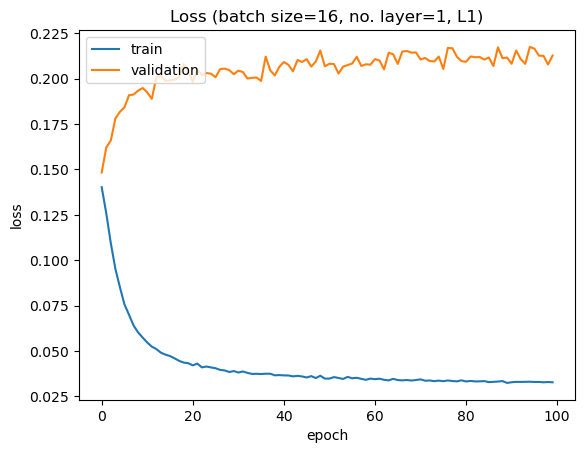

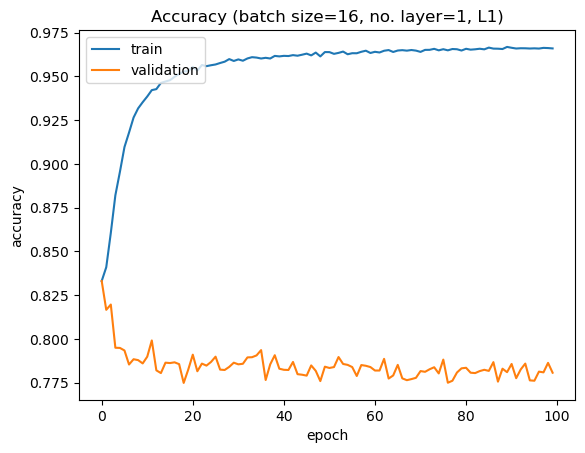

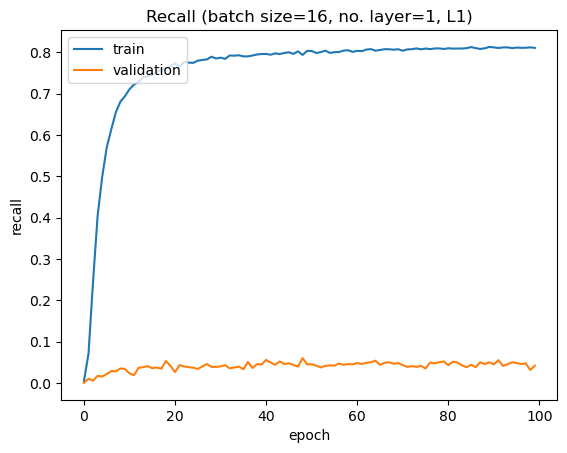

In [9]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [10]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.033
Training Accuracy: 0.966
Training Recall: 0.811


Validation Loss: 0.213
Validation Accuracy: 0.781
Validation Recall: 0.042


### batch size = 32, number of layer = 1

In [11]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1392 - accuracy: 0.8335 - recall_1: 0.0052 - val_loss: 0.1499 - val_accuracy: 0.8328 - val_recall_1: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1182 - accuracy: 0.8472 - recall_1: 0.1286 - val_loss: 0.1617 - val_accuracy: 0.8189 - val_recall_1: 0.0063 - 2s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 1s - loss: 0.0965 - accuracy: 0.8784 - recall_1: 0.3584 - val_loss: 0.1743 - val_accuracy: 0.8034 - val_recall_1: 0.0213 - 1s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.0780 - accuracy: 0.9072 - recall_1: 0.5392 - val_loss: 0.1859 - val_accuracy: 0.7850 - val_recall_1: 0.0206 - 2s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.0643 - accuracy: 0.9263 - recall_1: 0.6480 - val_loss: 0.1825 - val_accuracy: 0.7985 - val_recall_1: 0.0137 - 2s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.0561 - accuracy: 0.9358 - recall_1: 0.6964 - val_loss: 0.1923 - val_accuracy: 0.7835 - val_recall_1: 0.0219 - 2s/epoch - 1ms

Epoch 50/100
1200/1200 - 2s - loss: 0.0253 - accuracy: 0.9739 - recall_1: 0.8564 - val_loss: 0.2123 - val_accuracy: 0.7780 - val_recall_1: 0.0356 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.0259 - accuracy: 0.9733 - recall_1: 0.8542 - val_loss: 0.2148 - val_accuracy: 0.7752 - val_recall_1: 0.0381 - 2s/epoch - 1ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.0255 - accuracy: 0.9734 - recall_1: 0.8548 - val_loss: 0.2156 - val_accuracy: 0.7758 - val_recall_1: 0.0338 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.0246 - accuracy: 0.9749 - recall_1: 0.8591 - val_loss: 0.2070 - val_accuracy: 0.7862 - val_recall_1: 0.0331 - 2s/epoch - 2ms/step
Epoch 54/100
1200/1200 - 2s - loss: 0.0249 - accuracy: 0.9742 - recall_1: 0.8573 - val_loss: 0.2153 - val_accuracy: 0.7768 - val_recall_1: 0.0344 - 2s/epoch - 2ms/step
Epoch 55/100
1200/1200 - 2s - loss: 0.0243 - accuracy: 0.9749 - recall_1: 0.8611 - val_loss: 0.2189 - val_accuracy: 0.7701 - val_recall_1: 0.0369 - 2s/epoch - 2

Epoch 99/100
1200/1200 - 2s - loss: 0.0240 - accuracy: 0.9754 - recall_1: 0.8627 - val_loss: 0.2109 - val_accuracy: 0.7818 - val_recall_1: 0.0325 - 2s/epoch - 1ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.0236 - accuracy: 0.9760 - recall_1: 0.8641 - val_loss: 0.2065 - val_accuracy: 0.7873 - val_recall_1: 0.0281 - 2s/epoch - 1ms/step


#### Predict

In [12]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

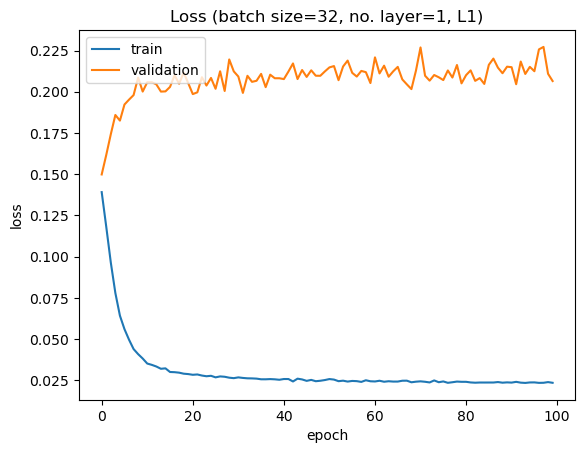

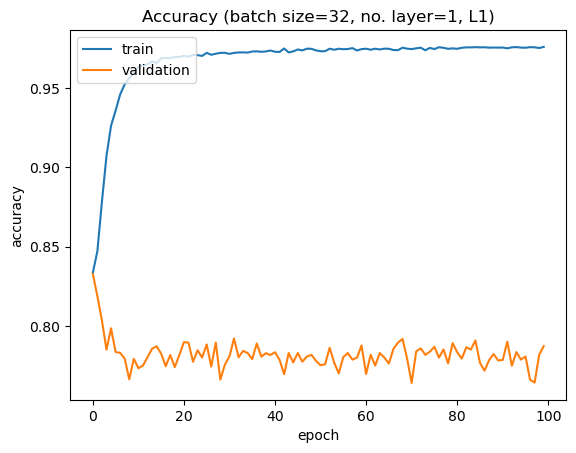

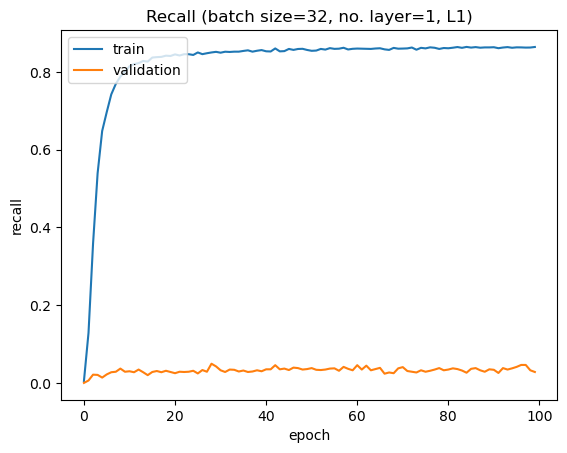

In [13]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [14]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.024
Training Accuracy: 0.976
Training Recall: 0.864


Validation Loss: 0.206
Validation Accuracy: 0.787
Validation Recall: 0.028


### batch size = 64, number of layer = 1

In [15]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1411 - accuracy: 0.8329 - recall_2: 0.0048 - val_loss: 0.1478 - val_accuracy: 0.8333 - val_recall_2: 0.0031 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1235 - accuracy: 0.8409 - recall_2: 0.0661 - val_loss: 0.1532 - val_accuracy: 0.8315 - val_recall_2: 0.0025 - 848ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1051 - accuracy: 0.8675 - recall_2: 0.2617 - val_loss: 0.1662 - val_accuracy: 0.8122 - val_recall_2: 0.0144 - 859ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.0877 - accuracy: 0.8952 - recall_2: 0.4508 - val_loss: 0.1701 - val_accuracy: 0.8116 - val_recall_2: 0.0188 - 867ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0734 - accuracy: 0.9151 - recall_2: 0.5767 - val_loss: 0.1807 - val_accuracy: 0.7921 - val_recall_2: 0.0256 - 866ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0617 - accuracy: 0.9313 - recall_2: 0.6630 - val_loss: 0.1811 - val_accuracy: 0.7987 - val_recall_2: 0.0250 - 858ms/epoch - 1ms/

Epoch 50/100
600/600 - 1s - loss: 0.0234 - accuracy: 0.9760 - recall_2: 0.8661 - val_loss: 0.1948 - val_accuracy: 0.7978 - val_recall_2: 0.0225 - 832ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0228 - accuracy: 0.9768 - recall_2: 0.8686 - val_loss: 0.2010 - val_accuracy: 0.7919 - val_recall_2: 0.0338 - 866ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0225 - accuracy: 0.9772 - recall_2: 0.8689 - val_loss: 0.2042 - val_accuracy: 0.7860 - val_recall_2: 0.0325 - 873ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0233 - accuracy: 0.9761 - recall_2: 0.8672 - val_loss: 0.2001 - val_accuracy: 0.7926 - val_recall_2: 0.0369 - 835ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0227 - accuracy: 0.9774 - recall_2: 0.8695 - val_loss: 0.2032 - val_accuracy: 0.7879 - val_recall_2: 0.0275 - 885ms/epoch - 1ms/step
Epoch 55/100
600/600 - 1s - loss: 0.0231 - accuracy: 0.9764 - recall_2: 0.8659 - val_loss: 0.1938 - val_accuracy: 0.8001 - val_recall_2: 0.0231 - 869ms/epo

Epoch 99/100
600/600 - 1s - loss: 0.0217 - accuracy: 0.9780 - recall_2: 0.8736 - val_loss: 0.2053 - val_accuracy: 0.7876 - val_recall_2: 0.0356 - 881ms/epoch - 1ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0218 - accuracy: 0.9777 - recall_2: 0.8725 - val_loss: 0.2086 - val_accuracy: 0.7849 - val_recall_2: 0.0388 - 871ms/epoch - 1ms/step


#### Predict

In [16]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

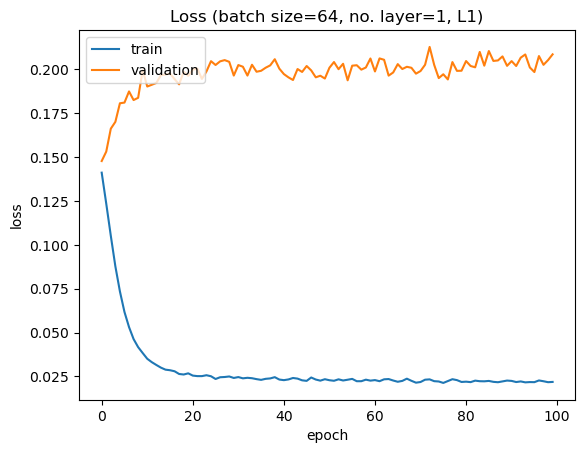

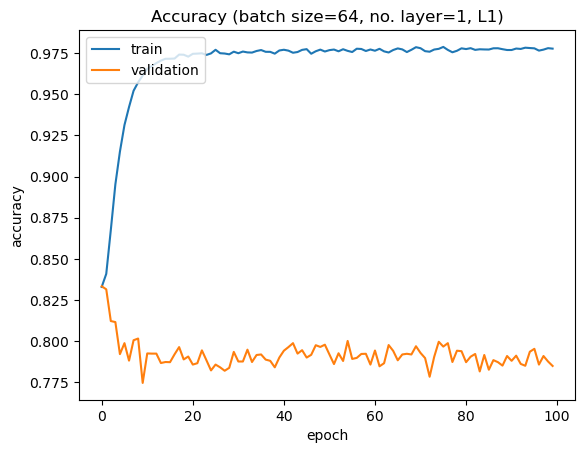

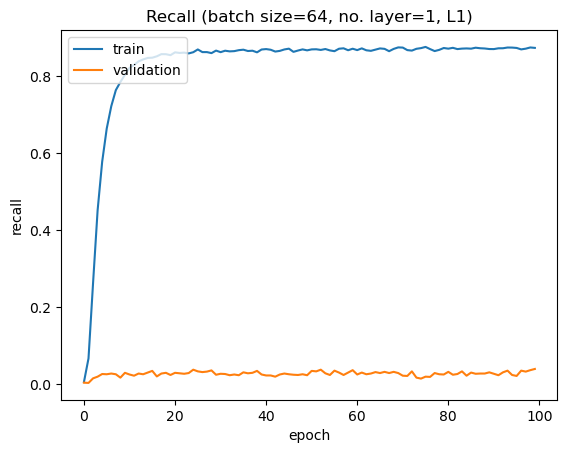

In [17]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [18]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.022
Training Accuracy: 0.978
Training Recall: 0.873


Validation Loss: 0.209
Validation Accuracy: 0.785
Validation Recall: 0.039


### batch size = 16, number of layer = 2

In [19]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [20]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1503 - accuracy: 0.8310 - recall_3: 0.0034 - val_loss: 0.1542 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1419 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1420 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1400 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.1391 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - v

Epoch 48/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 49/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 50/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 

Epoch 95/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 96/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 97/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 98/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 99/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_3: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 100/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_3: 0.0000e+00 - val_loss: 0.1389 - val_accuracy:

#### Predict

In [21]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

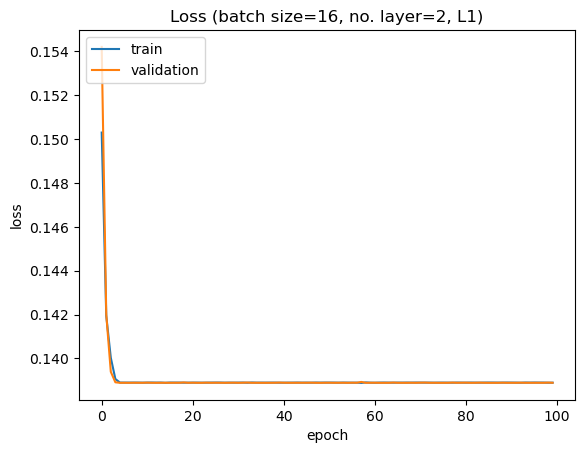

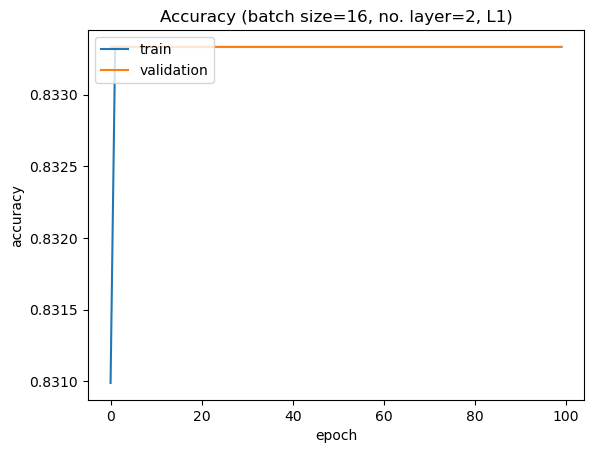

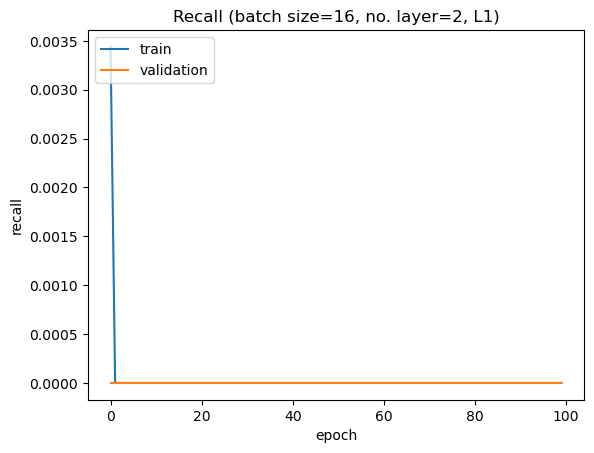

In [22]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [23]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [24]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1487 - accuracy: 0.8318 - recall_4: 0.0033 - val_loss: 0.1613 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1429 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1491 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1409 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1450 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1401 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1396 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1400 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1392 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - v

Epoch 48/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1414 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 49/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1419 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 50/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1400 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1429 - val_accuracy: 

Epoch 95/100
1200/1200 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1457 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 96/100
1200/1200 - 2s - loss: 0.1385 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1423 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 97/100
1200/1200 - 2s - loss: 0.1385 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1444 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 98/100
1200/1200 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1442 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 99/100
1200/1200 - 2s - loss: 0.1385 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1445 - val_accuracy: 0.8333 - val_recall_4: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.1385 - accuracy: 0.8333 - recall_4: 0.0000e+00 - val_loss: 0.1458 - val_accuracy:

#### Predict

In [25]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

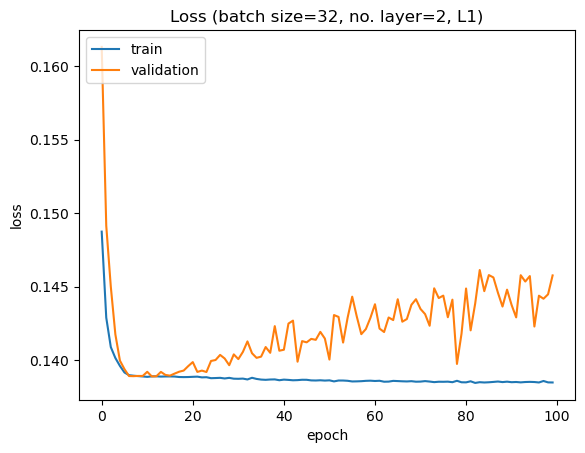

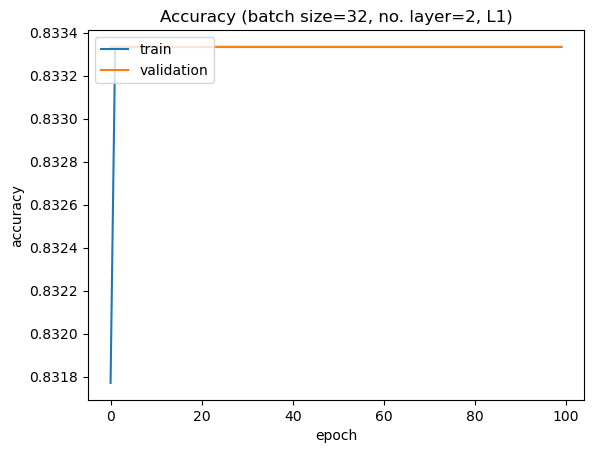

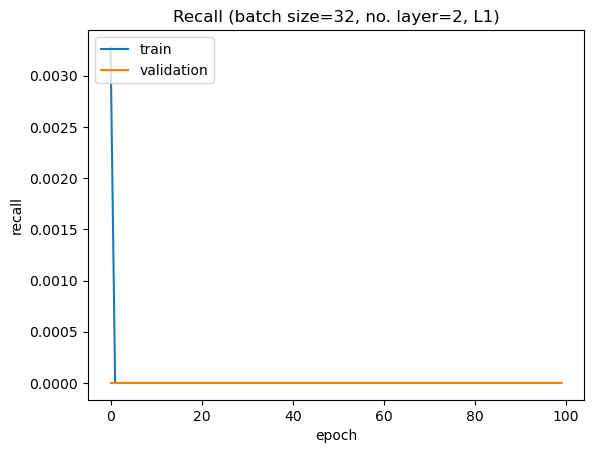

In [26]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [27]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.146
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [28]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1473 - accuracy: 0.8323 - recall_5: 4.6875e-04 - val_loss: 0.1653 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1432 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1588 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 840ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1420 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1502 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 837ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1411 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1492 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 831ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1406 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1446 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 832ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1396 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1434 - val_accuracy: 0.8333

Epoch 48/100
600/600 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1386 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val

Epoch 95/100
600/600 - 1s - loss: 0.1384 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1415 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1413 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1414 - val_accuracy: 0.8333 - val_recall_5: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1383 - accuracy: 0.8333 - recall_5: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - va

#### Predict

In [29]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

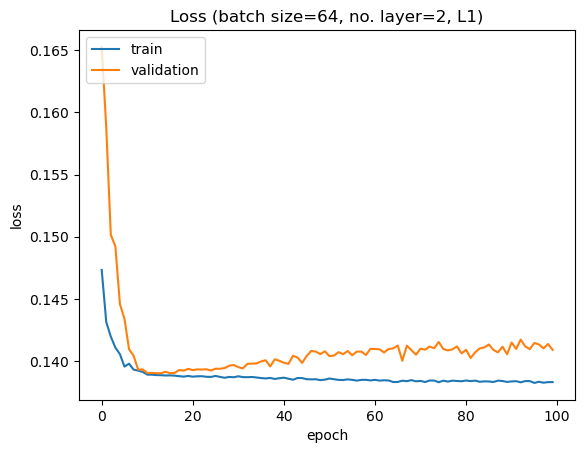

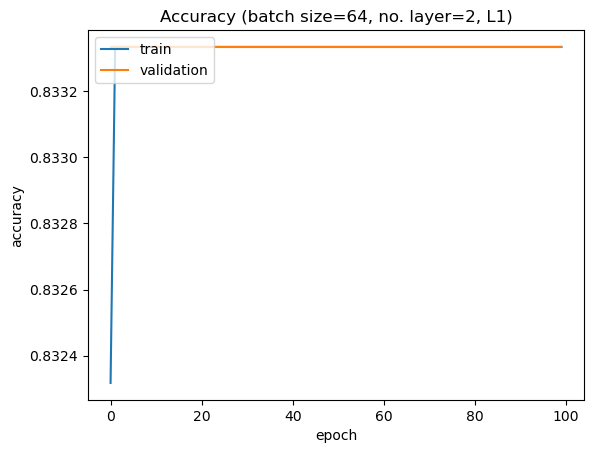

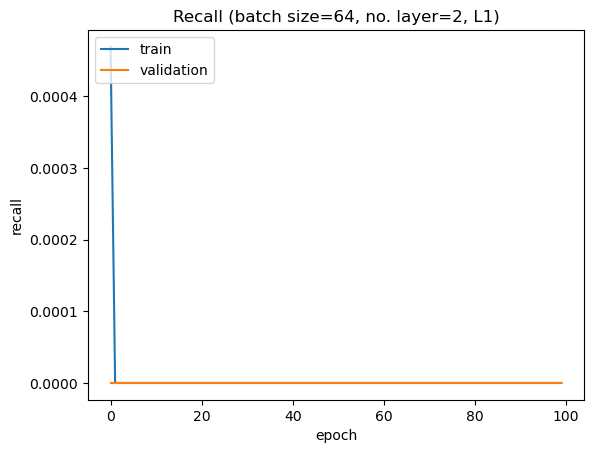

In [30]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [31]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.141
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [32]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
left_train_augmented = np.load('AUG_resnet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [33]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [34]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [35]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1663 - accuracy: 0.8322 - recall_6: 0.0039 - val_loss: 0.1663 - val_accuracy: 0.8281 - val_recall_6: 0.0056 - 5s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 4s - loss: 0.1608 - accuracy: 0.8334 - recall_6: 0.0297 - val_loss: 0.1530 - val_accuracy: 0.8282 - val_recall_6: 0.0031 - 4s/epoch - 2ms/step
Epoch 3/100
2400/2400 - 4s - loss: 0.1391 - accuracy: 0.8350 - recall_6: 0.0203 - val_loss: 0.1479 - val_accuracy: 0.8331 - val_recall_6: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 4/100
2400/2400 - 4s - loss: 0.1286 - accuracy: 0.8414 - recall_6: 0.0842 - val_loss: 0.1576 - val_accuracy: 0.8248 - val_recall_6: 0.0025 - 4s/epoch - 2ms/step
Epoch 5/100
2400/2400 - 4s - loss: 0.1144 - accuracy: 0.8584 - recall_6: 0.2375 - val_loss: 0.1648 - val_accuracy: 0.8169 - val_recall_6: 0.0025 - 4s/epoch - 2ms/step
Epoch 6/100
2400/2400 - 4s - loss: 0.1008 - accuracy: 0.8765 - recall_6: 0.3714 - val_loss: 0.1686 - val_accuracy: 0.8171 - val_recall_6: 0.0019 - 4s/epoch - 2ms

Epoch 50/100
2400/2400 - 4s - loss: 0.0392 - accuracy: 0.9592 - recall_6: 0.7744 - val_loss: 0.2060 - val_accuracy: 0.7844 - val_recall_6: 0.0250 - 4s/epoch - 2ms/step
Epoch 51/100
2400/2400 - 4s - loss: 0.0391 - accuracy: 0.9594 - recall_6: 0.7759 - val_loss: 0.1949 - val_accuracy: 0.7977 - val_recall_6: 0.0250 - 4s/epoch - 2ms/step
Epoch 52/100
2400/2400 - 4s - loss: 0.0386 - accuracy: 0.9599 - recall_6: 0.7783 - val_loss: 0.2035 - val_accuracy: 0.7875 - val_recall_6: 0.0231 - 4s/epoch - 2ms/step
Epoch 53/100
2400/2400 - 4s - loss: 0.0386 - accuracy: 0.9600 - recall_6: 0.7764 - val_loss: 0.1967 - val_accuracy: 0.7946 - val_recall_6: 0.0206 - 4s/epoch - 2ms/step
Epoch 54/100
2400/2400 - 4s - loss: 0.0382 - accuracy: 0.9605 - recall_6: 0.7828 - val_loss: 0.2065 - val_accuracy: 0.7851 - val_recall_6: 0.0288 - 4s/epoch - 2ms/step
Epoch 55/100
2400/2400 - 4s - loss: 0.0387 - accuracy: 0.9599 - recall_6: 0.7773 - val_loss: 0.1872 - val_accuracy: 0.8077 - val_recall_6: 0.0188 - 4s/epoch - 2

Epoch 99/100
2400/2400 - 4s - loss: 0.0370 - accuracy: 0.9621 - recall_6: 0.7856 - val_loss: 0.1991 - val_accuracy: 0.7951 - val_recall_6: 0.0213 - 4s/epoch - 2ms/step
Epoch 100/100
2400/2400 - 4s - loss: 0.0370 - accuracy: 0.9623 - recall_6: 0.7839 - val_loss: 0.1956 - val_accuracy: 0.7998 - val_recall_6: 0.0200 - 4s/epoch - 2ms/step


#### Predict

In [36]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

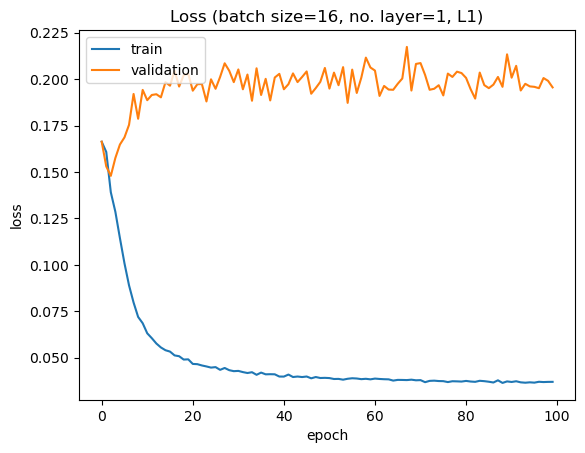

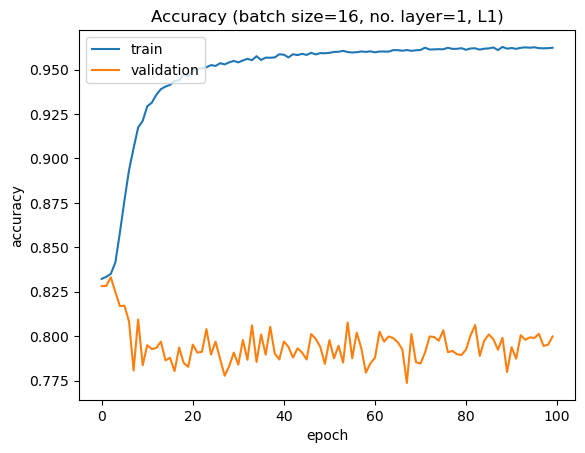

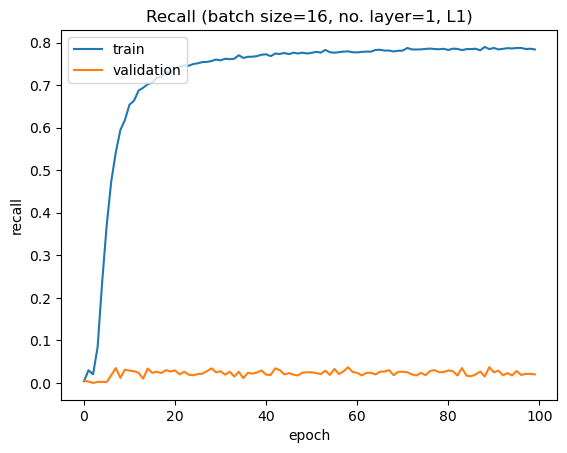

In [37]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [38]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.037
Training Accuracy: 0.962
Training Recall: 0.784


Validation Loss: 0.196
Validation Accuracy: 0.8
Validation Recall: 0.02


### batch size = 32, number of layer = 1

In [39]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1659 - accuracy: 0.8325 - recall_7: 0.0075 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_7: 0.0000e+00 - 3s/epoch - 3ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1633 - accuracy: 0.8346 - recall_7: 0.0219 - val_loss: 0.1675 - val_accuracy: 0.8297 - val_recall_7: 0.0012 - 2s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1587 - accuracy: 0.8391 - recall_7: 0.0511 - val_loss: 0.1670 - val_accuracy: 0.8318 - val_recall_7: 6.2500e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1536 - accuracy: 0.8439 - recall_7: 0.0831 - val_loss: 0.1667 - val_accuracy: 0.8316 - val_recall_7: 0.0044 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1478 - accuracy: 0.8503 - recall_7: 0.1161 - val_loss: 0.1687 - val_accuracy: 0.8290 - val_recall_7: 0.0031 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1435 - accuracy: 0.8548 - recall_7: 0.1452 - val_loss: 0.1677 - val_accuracy: 0.8296 - val_recall_7: 0.0037 - 2s/epoch -

Epoch 50/100
1200/1200 - 2s - loss: 0.1266 - accuracy: 0.8731 - recall_7: 0.2423 - val_loss: 0.1738 - val_accuracy: 0.8251 - val_recall_7: 0.0063 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.1261 - accuracy: 0.8737 - recall_7: 0.2452 - val_loss: 0.1704 - val_accuracy: 0.8288 - val_recall_7: 6.2500e-04 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.1260 - accuracy: 0.8739 - recall_7: 0.2456 - val_loss: 0.1696 - val_accuracy: 0.8298 - val_recall_7: 0.0037 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.1264 - accuracy: 0.8733 - recall_7: 0.2439 - val_loss: 0.1722 - val_accuracy: 0.8271 - val_recall_7: 0.0056 - 2s/epoch - 2ms/step
Epoch 54/100
1200/1200 - 2s - loss: 0.1259 - accuracy: 0.8739 - recall_7: 0.2452 - val_loss: 0.1707 - val_accuracy: 0.8284 - val_recall_7: 0.0069 - 2s/epoch - 2ms/step
Epoch 55/100
1200/1200 - 2s - loss: 0.1261 - accuracy: 0.8737 - recall_7: 0.2447 - val_loss: 0.1731 - val_accuracy: 0.8261 - val_recall_7: 0.0056 - 2s/epoch

Epoch 99/100
1200/1200 - 2s - loss: 0.1255 - accuracy: 0.8744 - recall_7: 0.2484 - val_loss: 0.1702 - val_accuracy: 0.8294 - val_recall_7: 0.0037 - 2s/epoch - 2ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.1250 - accuracy: 0.8749 - recall_7: 0.2511 - val_loss: 0.1703 - val_accuracy: 0.8291 - val_recall_7: 0.0056 - 2s/epoch - 2ms/step


#### Predict

In [40]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

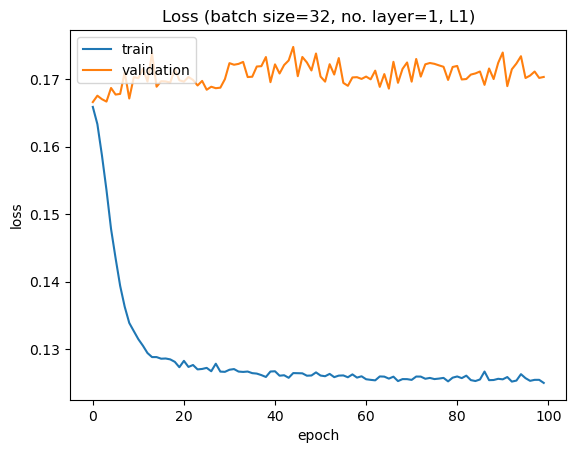

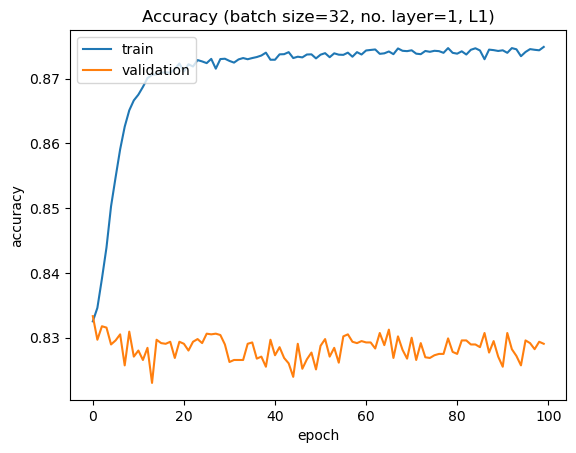

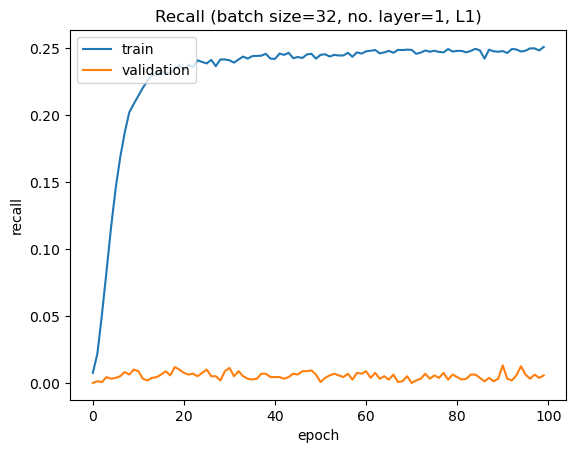

In [41]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [42]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.125
Training Accuracy: 0.875
Training Recall: 0.251


Validation Loss: 0.17
Validation Accuracy: 0.829
Validation Recall: 0.006


### batch size = 64, number of layer = 1

In [43]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1613 - accuracy: 0.8311 - recall_8: 0.0227 - val_loss: 0.1642 - val_accuracy: 0.8313 - val_recall_8: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1468 - accuracy: 0.8396 - recall_8: 0.0977 - val_loss: 0.1595 - val_accuracy: 0.8195 - val_recall_8: 0.0131 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1284 - accuracy: 0.8559 - recall_8: 0.1963 - val_loss: 0.1636 - val_accuracy: 0.8129 - val_recall_8: 0.0119 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1128 - accuracy: 0.8732 - recall_8: 0.3086 - val_loss: 0.1668 - val_accuracy: 0.8154 - val_recall_8: 0.0188 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0992 - accuracy: 0.8902 - recall_8: 0.4130 - val_loss: 0.1686 - val_accuracy: 0.8196 - val_recall_8: 0.0119 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0875 - accuracy: 0.9052 - recall_8: 0.4947 - val_loss: 0.1843 - val_accuracy: 0.7927 - val_recall_8: 0.0394 - 1s/epoch - 2ms/step
Epoch 

Epoch 51/100
600/600 - 1s - loss: 0.0523 - accuracy: 0.9466 - recall_8: 0.6923 - val_loss: 0.1886 - val_accuracy: 0.8054 - val_recall_8: 0.0256 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0521 - accuracy: 0.9472 - recall_8: 0.6947 - val_loss: 0.1864 - val_accuracy: 0.8087 - val_recall_8: 0.0250 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0520 - accuracy: 0.9469 - recall_8: 0.6941 - val_loss: 0.1895 - val_accuracy: 0.8052 - val_recall_8: 0.0300 - 1s/epoch - 2ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0510 - accuracy: 0.9483 - recall_8: 0.6986 - val_loss: 0.1895 - val_accuracy: 0.8051 - val_recall_8: 0.0269 - 1s/epoch - 2ms/step
Epoch 55/100
600/600 - 1s - loss: 0.0528 - accuracy: 0.9461 - recall_8: 0.6920 - val_loss: 0.1902 - val_accuracy: 0.8037 - val_recall_8: 0.0344 - 1s/epoch - 2ms/step
Epoch 56/100
600/600 - 1s - loss: 0.0508 - accuracy: 0.9486 - recall_8: 0.6997 - val_loss: 0.1905 - val_accuracy: 0.8040 - val_recall_8: 0.0319 - 1s/epoch - 2ms/step
Epoc

#### Predict

In [44]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

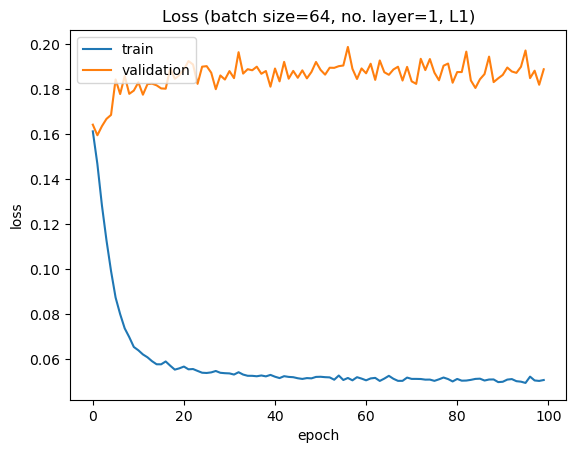

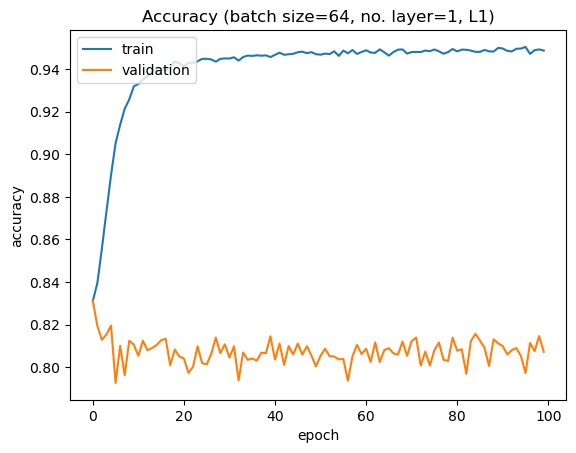

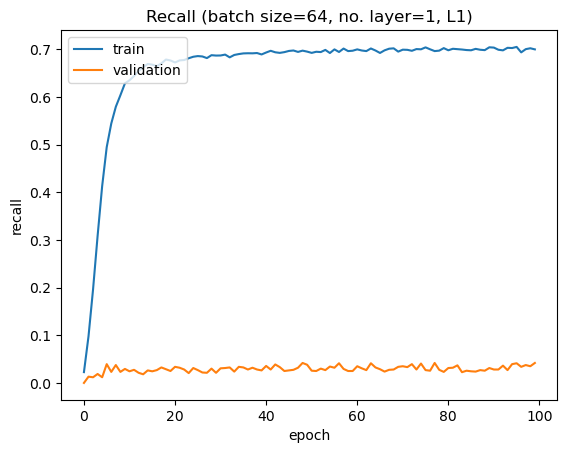

In [45]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [46]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.051
Training Accuracy: 0.949
Training Recall: 0.7


Validation Loss: 0.189
Validation Accuracy: 0.807
Validation Recall: 0.042


### batch size = 16, number of layer = 2

In [47]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [48]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1669 - accuracy: 0.8328 - recall_9: 3.1250e-04 - val_loss: 0.1655 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 5s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1655 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 3/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 5/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 6/100
2400/2400 - 5s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1666 - val_accuracy: 0.8333

Epoch 48/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 49/100
2400/2400 - 4s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 50/100
2400/2400 - 4s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 1.5625e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 4s - loss: 0.1668 - accuracy: 0.8332 - recall_9: 1.5625e-04 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 

Epoch 95/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 96/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 97/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 98/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 99/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_9: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 100/100
2400/2400 - 4s - loss: 0.1667 - accuracy: 0.8333 - recall_9: 0.0000e+00 - val_loss: 0.1667 - val_accuracy:

#### Predict

In [49]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

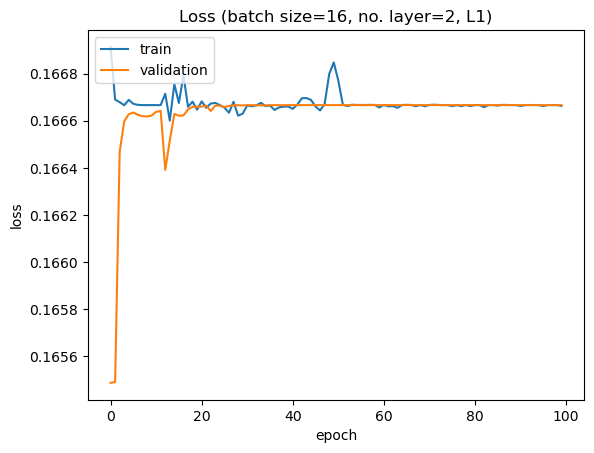

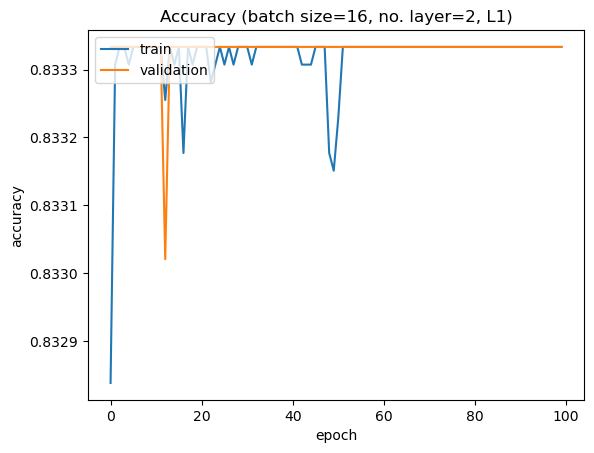

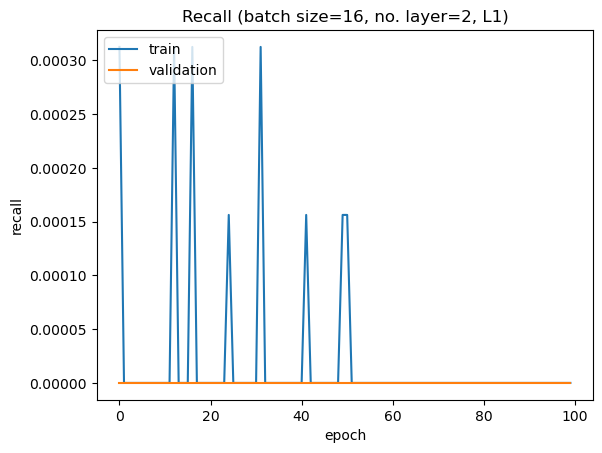

In [50]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [51]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [52]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 4s - loss: 0.1672 - accuracy: 0.8321 - recall_10: 7.8125e-04 - val_loss: 0.1655 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 4s/epoch - 3ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1666 - accuracy: 0.8333 - recall_10: 1.5625e-04 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 1.5625e-04 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1666 - accuracy: 0.8334 - recall_10: 1.5625e-04 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1666 - val_accur

Epoch 48/100
1200/1200 - 3s - loss: 0.1666 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 49/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 50/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val

1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 95/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 96/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 97/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 98/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_10: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 99/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_10: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.

#### Predict

In [53]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

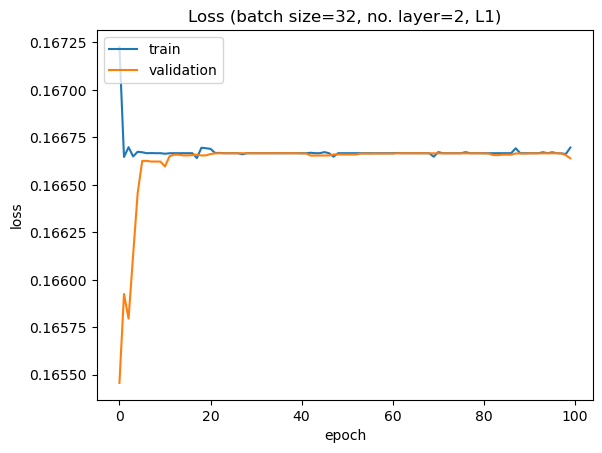

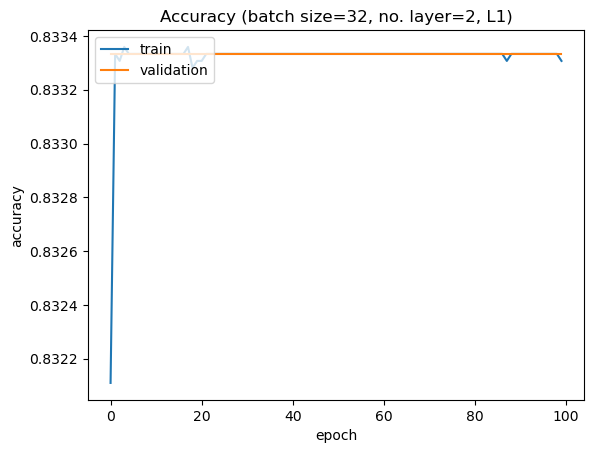

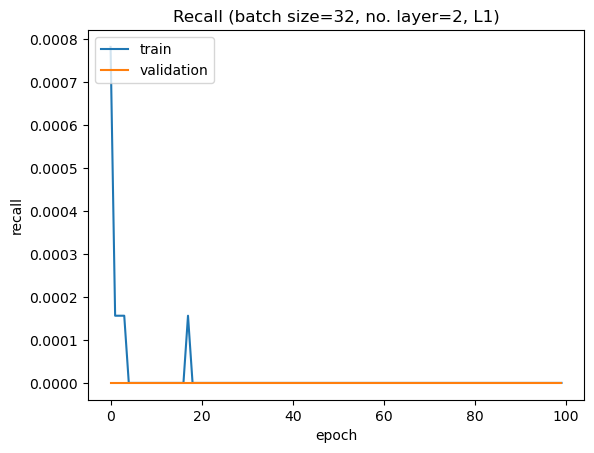

In [54]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [55]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [56]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1680 - accuracy: 0.8305 - recall_11: 0.0036 - val_loss: 0.1641 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1645 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8332 - recall_11: 6.2500e-04 - val_loss: 0.1654 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 2s - loss: 0.1668 - accuracy: 0.8330 - recall_11: 1.5625e-04 - val_loss: 0.1664 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 5/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 6/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1665 - val_accuracy: 0.8333 - va

Epoch 48/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 50/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 2s - loss: 0.1666 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 53/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0

Epoch 95/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 96/100
600/600 - 2s - loss: 0.1666 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 99/100
600/600 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_11: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_11: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 

#### Predict

In [57]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

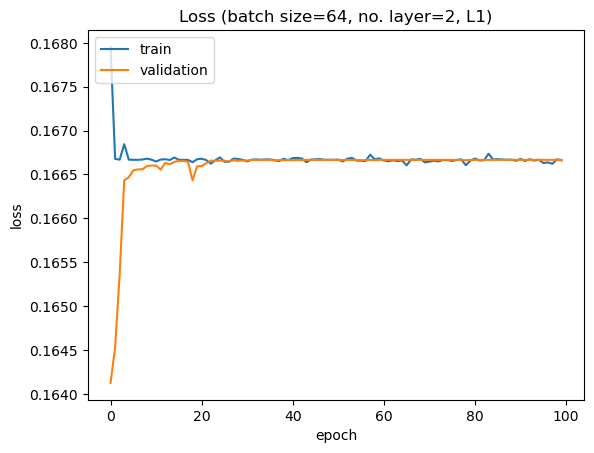

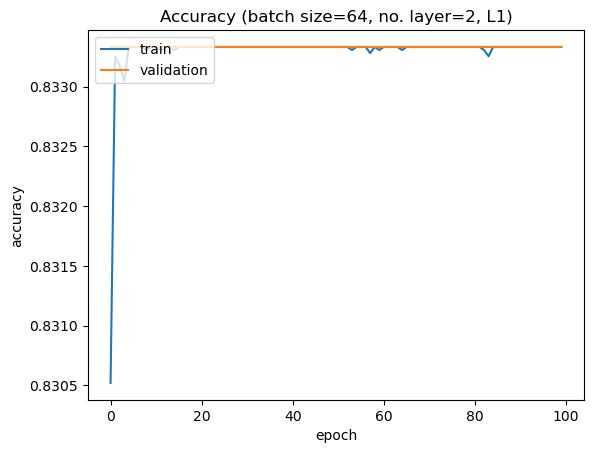

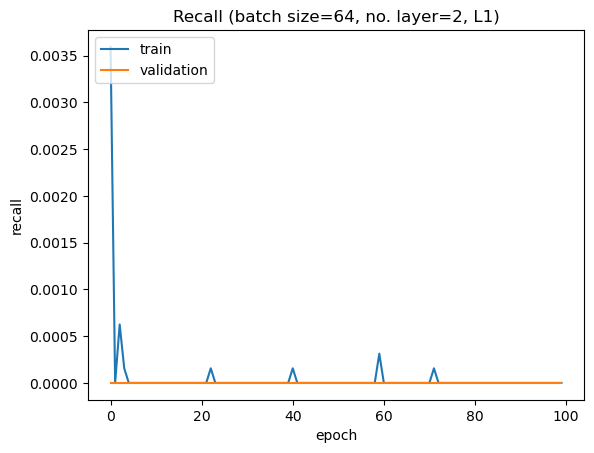

In [58]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [59]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [60]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
left_train_augmented = np.load('AUG_densenet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [61]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [62]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [63]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1660 - accuracy: 0.8330 - recall_12: 0.0073 - val_loss: 0.1663 - val_accuracy: 0.8335 - val_recall_12: 0.0025 - 4s/epoch - 1ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1629 - accuracy: 0.8358 - recall_12: 0.0277 - val_loss: 0.1668 - val_accuracy: 0.8331 - val_recall_12: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1596 - accuracy: 0.8399 - recall_12: 0.0466 - val_loss: 0.1678 - val_accuracy: 0.8307 - val_recall_12: 0.0025 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.1580 - accuracy: 0.8413 - recall_12: 0.0566 - val_loss: 0.1668 - val_accuracy: 0.8329 - val_recall_12: 0.0012 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 3s - loss: 0.1569 - accuracy: 0.8426 - recall_12: 0.0631 - val_loss: 0.1670 - val_accuracy: 0.8328 - val_recall_12: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 3s - loss: 0.1560 - accuracy: 0.8436 - recall_12: 0.0677 - val_loss: 0.1665 - val_accuracy: 0.8333 - val_recall_12: 0.0019 

Epoch 49/100
2400/2400 - 3s - loss: 0.1491 - accuracy: 0.8509 - recall_12: 0.1070 - val_loss: 0.1669 - val_accuracy: 0.8330 - val_recall_12: 0.0031 - 3s/epoch - 1ms/step
Epoch 50/100
2400/2400 - 3s - loss: 0.1494 - accuracy: 0.8505 - recall_12: 0.1055 - val_loss: 0.1672 - val_accuracy: 0.8326 - val_recall_12: 0.0025 - 3s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 3s - loss: 0.1491 - accuracy: 0.8509 - recall_12: 0.1061 - val_loss: 0.1681 - val_accuracy: 0.8318 - val_recall_12: 0.0050 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.1492 - accuracy: 0.8508 - recall_12: 0.1070 - val_loss: 0.1678 - val_accuracy: 0.8321 - val_recall_12: 0.0044 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.1492 - accuracy: 0.8508 - recall_12: 0.1063 - val_loss: 0.1677 - val_accuracy: 0.8321 - val_recall_12: 0.0044 - 3s/epoch - 1ms/step
Epoch 54/100
2400/2400 - 3s - loss: 0.1489 - accuracy: 0.8510 - recall_12: 0.1084 - val_loss: 0.1677 - val_accuracy: 0.8321 - val_recall_12: 0.0037 - 

Epoch 97/100
2400/2400 - 3s - loss: 0.1476 - accuracy: 0.8523 - recall_12: 0.1158 - val_loss: 0.1714 - val_accuracy: 0.8285 - val_recall_12: 6.2500e-04 - 3s/epoch - 1ms/step
Epoch 98/100
2400/2400 - 3s - loss: 0.1475 - accuracy: 0.8524 - recall_12: 0.1156 - val_loss: 0.1687 - val_accuracy: 0.8313 - val_recall_12: 6.2500e-04 - 3s/epoch - 1ms/step
Epoch 99/100
2400/2400 - 3s - loss: 0.1472 - accuracy: 0.8527 - recall_12: 0.1177 - val_loss: 0.1675 - val_accuracy: 0.8325 - val_recall_12: 6.2500e-04 - 3s/epoch - 1ms/step
Epoch 100/100
2400/2400 - 3s - loss: 0.1471 - accuracy: 0.8529 - recall_12: 0.1180 - val_loss: 0.1683 - val_accuracy: 0.8315 - val_recall_12: 6.2500e-04 - 3s/epoch - 1ms/step


#### Predict

In [64]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

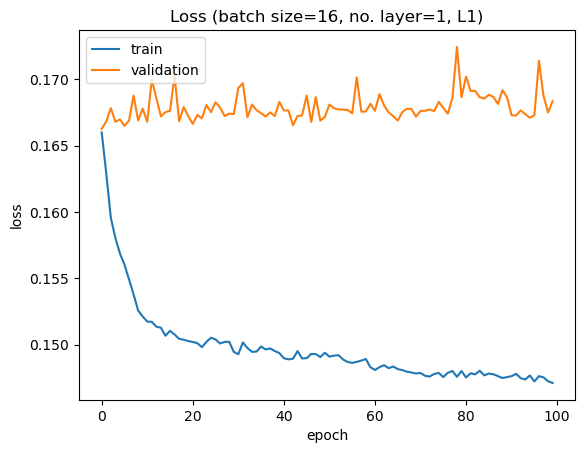

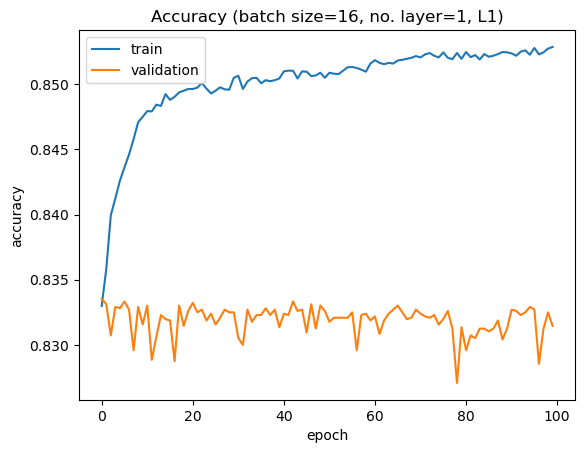

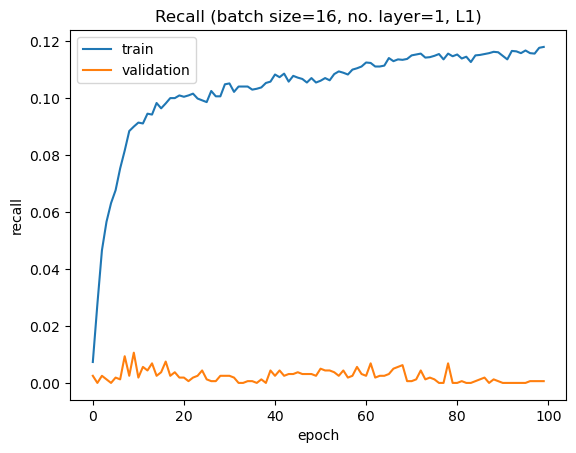

In [65]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [66]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.147
Training Accuracy: 0.853
Training Recall: 0.118


Validation Loss: 0.168
Validation Accuracy: 0.831
Validation Recall: 0.001


### batch size = 32, number of layer = 1

In [67]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1628 - accuracy: 0.8338 - recall_13: 0.0209 - val_loss: 0.1661 - val_accuracy: 0.8310 - val_recall_13: 0.0031 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1498 - accuracy: 0.8427 - recall_13: 0.0988 - val_loss: 0.1642 - val_accuracy: 0.8216 - val_recall_13: 0.0175 - 2s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 1s - loss: 0.1310 - accuracy: 0.8588 - recall_13: 0.2055 - val_loss: 0.1650 - val_accuracy: 0.8208 - val_recall_13: 0.0037 - 1s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1148 - accuracy: 0.8770 - recall_13: 0.3156 - val_loss: 0.1717 - val_accuracy: 0.8134 - val_recall_13: 0.0156 - 2s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 1s - loss: 0.1028 - accuracy: 0.8911 - recall_13: 0.3991 - val_loss: 0.1740 - val_accuracy: 0.8141 - val_recall_13: 0.0169 - 1s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 1s - loss: 0.0936 - accuracy: 0.9027 - recall_13: 0.4570 - val_loss: 0.1732 - val_accuracy: 0.8184 - val_recall_13: 0.0075 - 1s/epo

Epoch 50/100
1200/1200 - 2s - loss: 0.0736 - accuracy: 0.9256 - recall_13: 0.5617 - val_loss: 0.1859 - val_accuracy: 0.8107 - val_recall_13: 0.0269 - 2s/epoch - 1ms/step
Epoch 51/100
1200/1200 - 1s - loss: 0.0737 - accuracy: 0.9259 - recall_13: 0.5623 - val_loss: 0.1908 - val_accuracy: 0.8064 - val_recall_13: 0.0325 - 1s/epoch - 1ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.0735 - accuracy: 0.9260 - recall_13: 0.5627 - val_loss: 0.1857 - val_accuracy: 0.8116 - val_recall_13: 0.0231 - 2s/epoch - 1ms/step
Epoch 53/100
1200/1200 - 1s - loss: 0.0745 - accuracy: 0.9246 - recall_13: 0.5589 - val_loss: 0.1828 - val_accuracy: 0.8142 - val_recall_13: 0.0256 - 1s/epoch - 1ms/step
Epoch 54/100
1200/1200 - 1s - loss: 0.0736 - accuracy: 0.9258 - recall_13: 0.5623 - val_loss: 0.1898 - val_accuracy: 0.8053 - val_recall_13: 0.0256 - 1s/epoch - 1ms/step
Epoch 55/100
1200/1200 - 1s - loss: 0.0736 - accuracy: 0.9259 - recall_13: 0.5620 - val_loss: 0.1863 - val_accuracy: 0.8103 - val_recall_13: 0.0194 - 

Epoch 99/100
1200/1200 - 1s - loss: 0.0733 - accuracy: 0.9262 - recall_13: 0.5645 - val_loss: 0.1918 - val_accuracy: 0.8054 - val_recall_13: 0.0175 - 1s/epoch - 1ms/step
Epoch 100/100
1200/1200 - 1s - loss: 0.0731 - accuracy: 0.9266 - recall_13: 0.5663 - val_loss: 0.1919 - val_accuracy: 0.8053 - val_recall_13: 0.0325 - 1s/epoch - 1ms/step


#### Predict

In [68]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

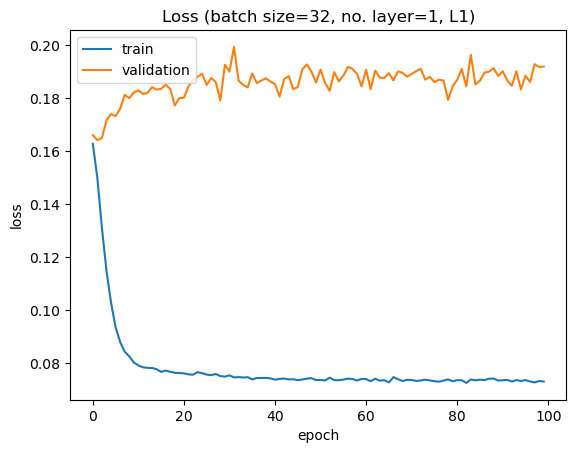

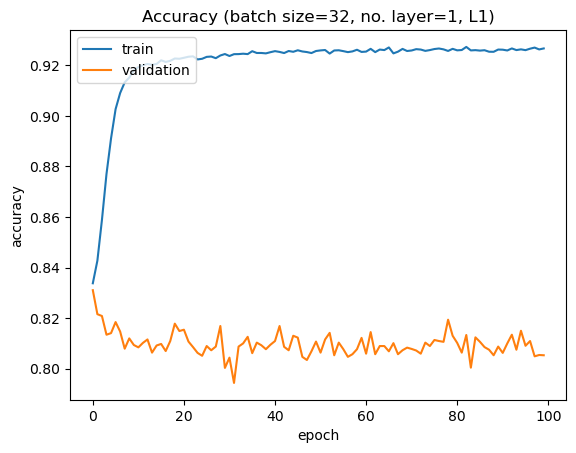

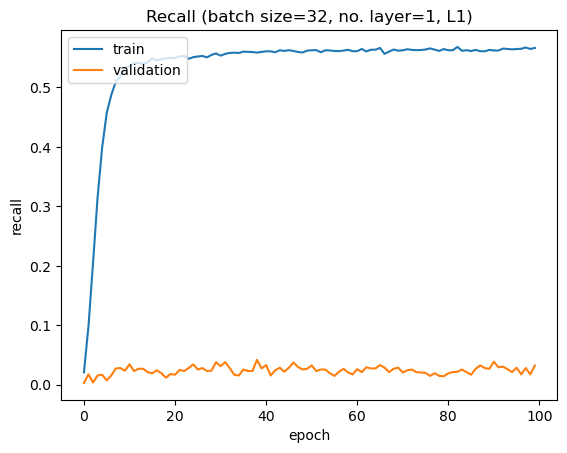

In [69]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [70]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.073
Training Accuracy: 0.927
Training Recall: 0.566


Validation Loss: 0.192
Validation Accuracy: 0.805
Validation Recall: 0.032


### batch size = 64, number of layer = 1

In [71]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 1s - loss: 0.1528 - accuracy: 0.8318 - recall_14: 0.0400 - val_loss: 0.1539 - val_accuracy: 0.8325 - val_recall_14: 0.0019 - 1s/epoch - 2ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1286 - accuracy: 0.8419 - recall_14: 0.0869 - val_loss: 0.1569 - val_accuracy: 0.8288 - val_recall_14: 6.2500e-04 - 776ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1126 - accuracy: 0.8613 - recall_14: 0.2280 - val_loss: 0.1698 - val_accuracy: 0.8042 - val_recall_14: 0.0162 - 785ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.0990 - accuracy: 0.8785 - recall_14: 0.3602 - val_loss: 0.1694 - val_accuracy: 0.8172 - val_recall_14: 0.0119 - 855ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.0878 - accuracy: 0.8957 - recall_14: 0.4680 - val_loss: 0.1755 - val_accuracy: 0.8059 - val_recall_14: 0.0156 - 883ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0787 - accuracy: 0.9090 - recall_14: 0.5430 - val_loss: 0.1826 - val_accuracy: 0.7944 - val_recall_14: 0.0181 - 81

Epoch 49/100
600/600 - 1s - loss: 0.0384 - accuracy: 0.9607 - recall_14: 0.7770 - val_loss: 0.1990 - val_accuracy: 0.7931 - val_recall_14: 0.0338 - 763ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.0376 - accuracy: 0.9617 - recall_14: 0.7803 - val_loss: 0.1985 - val_accuracy: 0.7926 - val_recall_14: 0.0394 - 763ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0386 - accuracy: 0.9604 - recall_14: 0.7772 - val_loss: 0.2031 - val_accuracy: 0.7865 - val_recall_14: 0.0344 - 748ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0392 - accuracy: 0.9596 - recall_14: 0.7723 - val_loss: 0.2002 - val_accuracy: 0.7907 - val_recall_14: 0.0400 - 766ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0380 - accuracy: 0.9610 - recall_14: 0.7788 - val_loss: 0.2004 - val_accuracy: 0.7907 - val_recall_14: 0.0425 - 795ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0376 - accuracy: 0.9618 - recall_14: 0.7797 - val_loss: 0.1961 - val_accuracy: 0.7964 - val_recall_14: 0.0250

Epoch 97/100
600/600 - 1s - loss: 0.0363 - accuracy: 0.9632 - recall_14: 0.7866 - val_loss: 0.2010 - val_accuracy: 0.7923 - val_recall_14: 0.0394 - 932ms/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.0362 - accuracy: 0.9634 - recall_14: 0.7870 - val_loss: 0.1959 - val_accuracy: 0.7980 - val_recall_14: 0.0325 - 876ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.0372 - accuracy: 0.9620 - recall_14: 0.7817 - val_loss: 0.1982 - val_accuracy: 0.7950 - val_recall_14: 0.0325 - 919ms/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0365 - accuracy: 0.9630 - recall_14: 0.7866 - val_loss: 0.1954 - val_accuracy: 0.7993 - val_recall_14: 0.0269 - 905ms/epoch - 2ms/step


#### Predict

In [72]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

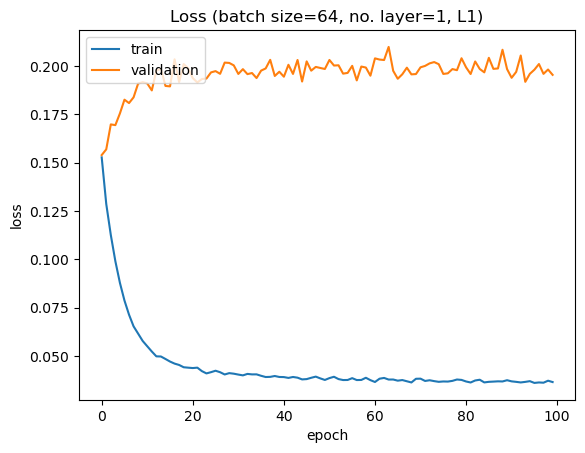

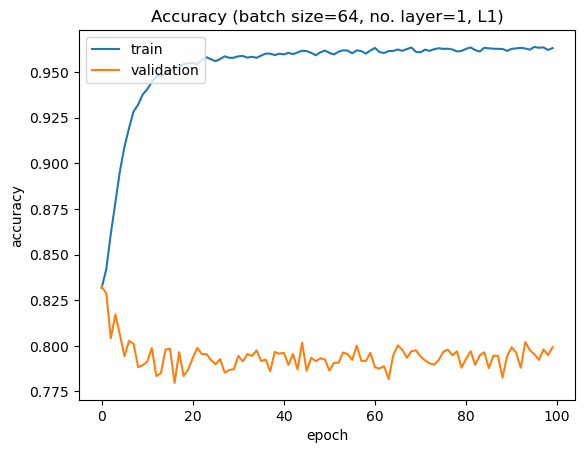

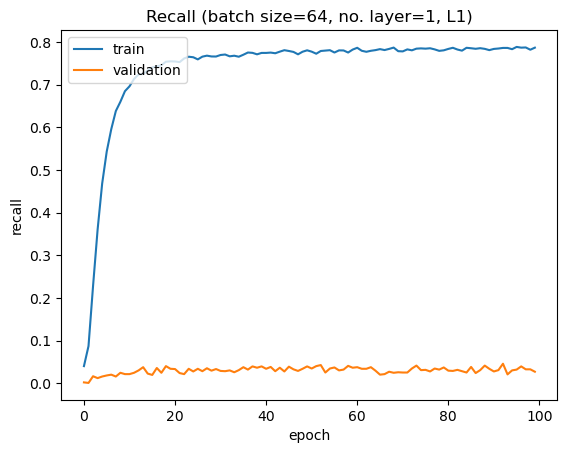

In [73]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [74]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.037
Training Accuracy: 0.963
Training Recall: 0.787


Validation Loss: 0.195
Validation Accuracy: 0.799
Validation Recall: 0.027


### batch size = 16, number of layer = 2

In [75]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L1_augmented\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L1_augmented\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [76]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1672 - accuracy: 0.8321 - recall_15: 0.0017 - val_loss: 0.1612 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1668 - accuracy: 0.8331 - recall_15: 1.5625e-04 - val_loss: 0.1638 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1651 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1659 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 3s - loss: 0.1668 - accuracy: 0.8331 - recall_15: 0.0000e+00 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 3s - loss: 0.1667 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1657 - val_accuracy:

Epoch 48/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 49/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 50/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val

2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 95/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 96/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 97/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 98/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_15: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 99/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_15: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.

#### Predict

In [77]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

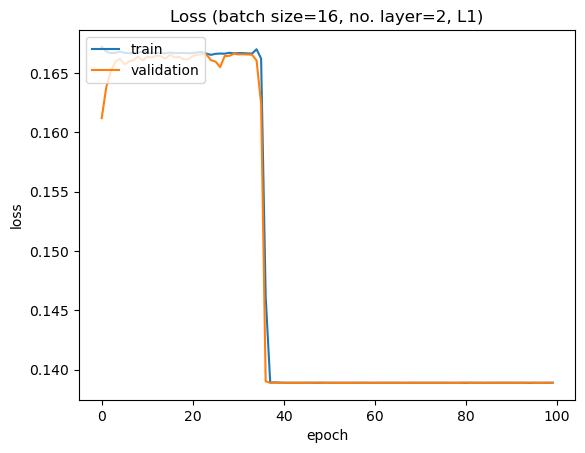

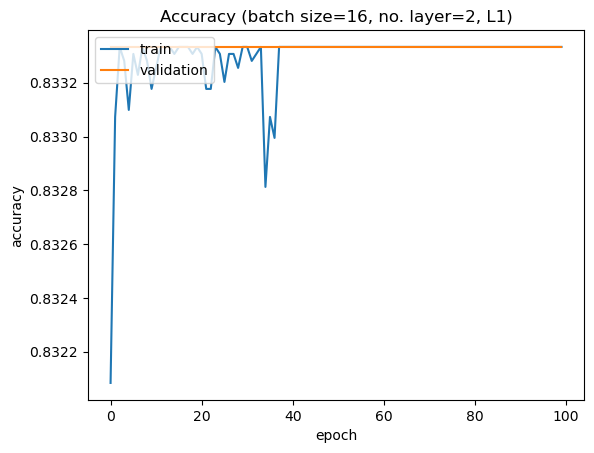

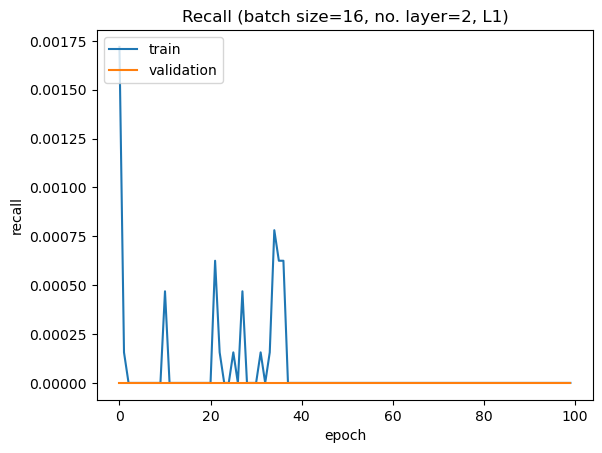

In [78]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [79]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [80]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8332 - recall_16: 0.0000e+00 - val_loss: 0.1656 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1658 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 1s - loss: 0.1668 - accuracy: 0.8332 - recall_16: 3.1250e-04 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 1s - loss: 0.1666 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1666 - val_accur

Epoch 48/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 49/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 50/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 51/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 52/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 53/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val

1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 95/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 96/100
1200/1200 - 2s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 97/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 98/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_16: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 99/100
1200/1200 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_16: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.

#### Predict

In [81]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

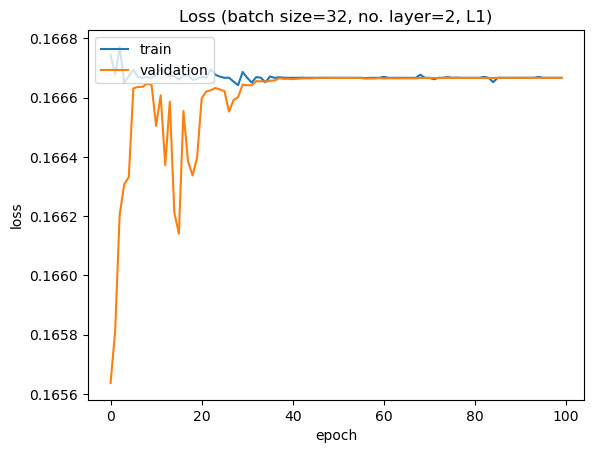

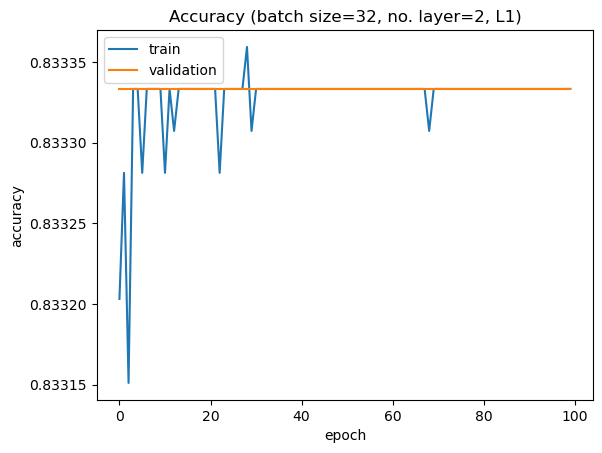

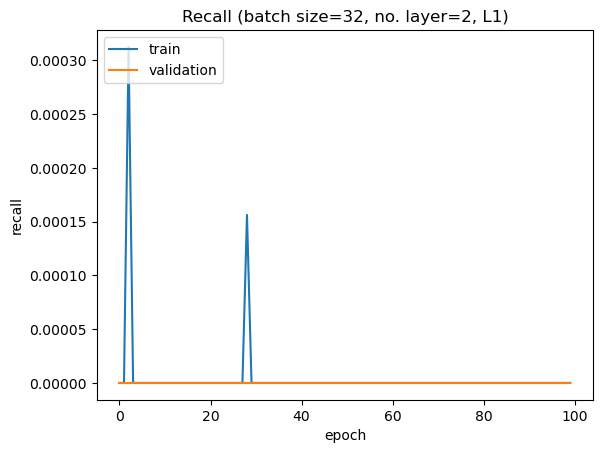

In [82]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [83]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [84]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.1672 - accuracy: 0.8326 - recall_17: 0.0011 - val_loss: 0.1660 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1662 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1661 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1663 - val_accuracy: 0.8333 - va

Epoch 48/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0

Epoch 95/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 0.8333 - val_recall_17: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1667 - accuracy: 0.8333 - recall_17: 0.0000e+00 - val_loss: 0.1667 - val_accuracy: 

#### Predict

In [85]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L1_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

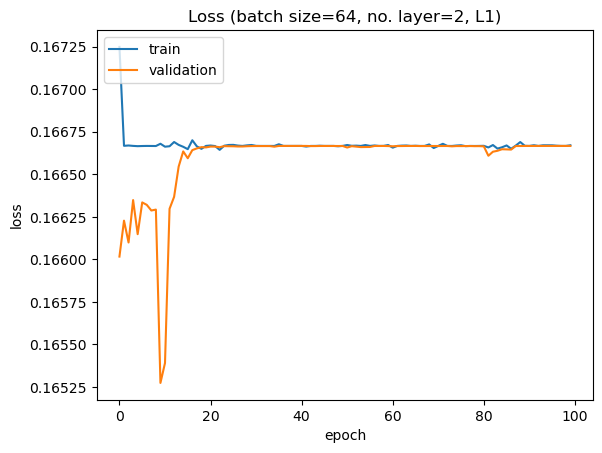

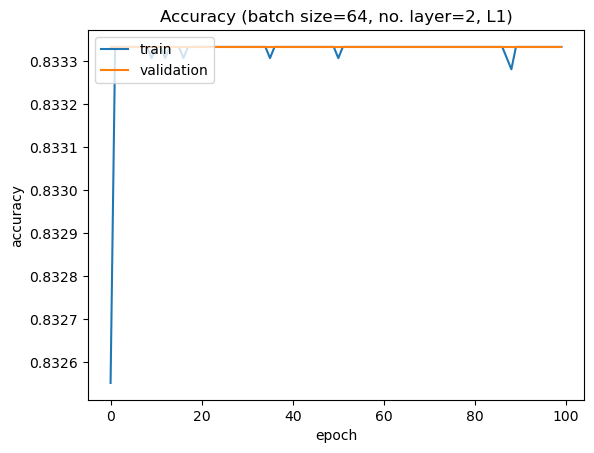

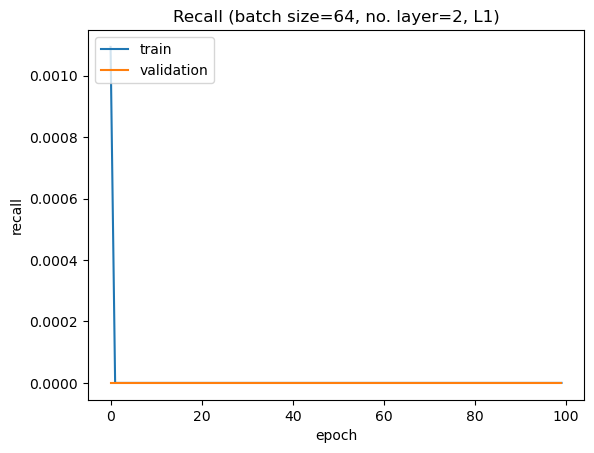

In [86]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L1)".format(batch_size, no_layer),
           batch_size=batch_size)

In [87]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.167
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.167
Validation Accuracy: 0.833
Validation Recall: 0.0


# L2 Distance

## vgg

In [88]:
left_train = np.load('vgg_train_left.npy')
left_train_augmented = np.load('AUG_vgg_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('vgg_train_right.npy')
left_test = np.load('vgg_test_left.npy')
right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [89]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [90]:
input_shape = (512,)
# input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

# Reference:
# https://keras.io/examples/vision/siamese_contrastive/?fbclid=IwAR0d0p7eAw2zZDUiyaPhkt-ZQuDQ32U7rRIHxv4ErsSn9yVkBFbfzBC42fQ
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    shared_network = create_shared_network(input_shape)
    left_features = shared_network(left_input)
    right_features = shared_network(right_input)

#     distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([left_features, right_features])
#     normal_layer = tf.keras.layers.BatchNormalization()(distance)
#     similarity_score = Dense(1, activation='sigmoid')(distance)
    
    distance = Lambda(euclidean_distance)([left_features, right_features])
    normal_layer = tf.keras.layers.BatchNormalization()(distance)
    similarity_score = layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_net = Model(inputs=[left_input, right_input], outputs=1-similarity_score)
    return siamese_net
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\vgg_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\vgg_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [91]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1581 - accuracy: 0.8151 - recall_18: 0.0378 - val_loss: 0.1427 - val_accuracy: 0.8333 - val_recall_18: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1319 - accuracy: 0.8334 - recall_18: 6.2500e-04 - val_loss: 0.1514 - val_accuracy: 0.8327 - val_recall_18: 6.2500e-04 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1234 - accuracy: 0.8363 - recall_18: 0.0578 - val_loss: 0.1623 - val_accuracy: 0.8216 - val_recall_18: 0.0100 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.1124 - accuracy: 0.8496 - recall_18: 0.2225 - val_loss: 0.1703 - val_accuracy: 0.8081 - val_recall_18: 0.0188 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 3s - loss: 0.1050 - accuracy: 0.8608 - recall_18: 0.3319 - val_loss: 0.1749 - val_accuracy: 0.7972 - val_recall_18: 0.0231 - 3s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 2s - loss: 0.0990 - accuracy: 0.8711 - recall_18: 0.4019 - val_loss: 0.1738 - val_accuracy: 0.8056 - val_recall_18: 0.0

Epoch 50/100
2400/2400 - 2s - loss: 0.0579 - accuracy: 0.9297 - recall_18: 0.7161 - val_loss: 0.1950 - val_accuracy: 0.7872 - val_recall_18: 0.0419 - 2s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 3s - loss: 0.0593 - accuracy: 0.9270 - recall_18: 0.7089 - val_loss: 0.1961 - val_accuracy: 0.7864 - val_recall_18: 0.0350 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.0572 - accuracy: 0.9298 - recall_18: 0.7138 - val_loss: 0.1975 - val_accuracy: 0.7826 - val_recall_18: 0.0437 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.0590 - accuracy: 0.9271 - recall_18: 0.7136 - val_loss: 0.1892 - val_accuracy: 0.7947 - val_recall_18: 0.0306 - 3s/epoch - 1ms/step
Epoch 54/100
2400/2400 - 3s - loss: 0.0589 - accuracy: 0.9272 - recall_18: 0.7166 - val_loss: 0.1989 - val_accuracy: 0.7808 - val_recall_18: 0.0431 - 3s/epoch - 1ms/step
Epoch 55/100
2400/2400 - 3s - loss: 0.0564 - accuracy: 0.9308 - recall_18: 0.7223 - val_loss: 0.1963 - val_accuracy: 0.7870 - val_recall_18: 0.0350 - 

Epoch 99/100
2400/2400 - 2s - loss: 0.0532 - accuracy: 0.9352 - recall_18: 0.7398 - val_loss: 0.2053 - val_accuracy: 0.7748 - val_recall_18: 0.0487 - 2s/epoch - 1ms/step
Epoch 100/100
2400/2400 - 2s - loss: 0.0529 - accuracy: 0.9354 - recall_18: 0.7375 - val_loss: 0.2002 - val_accuracy: 0.7827 - val_recall_18: 0.0431 - 2s/epoch - 1ms/step


#### Predict

In [92]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

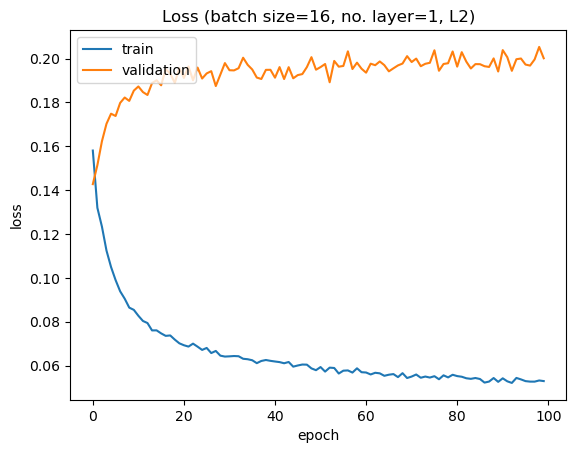

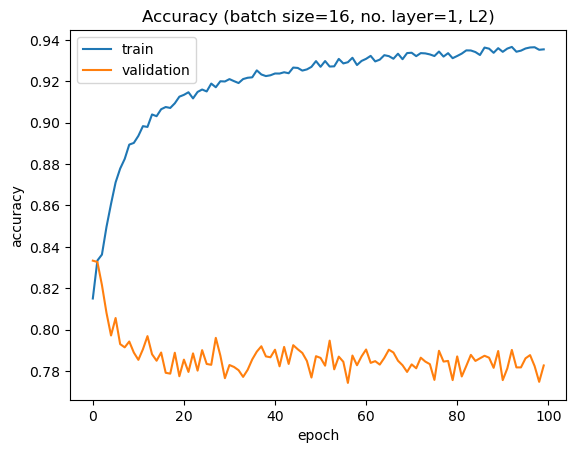

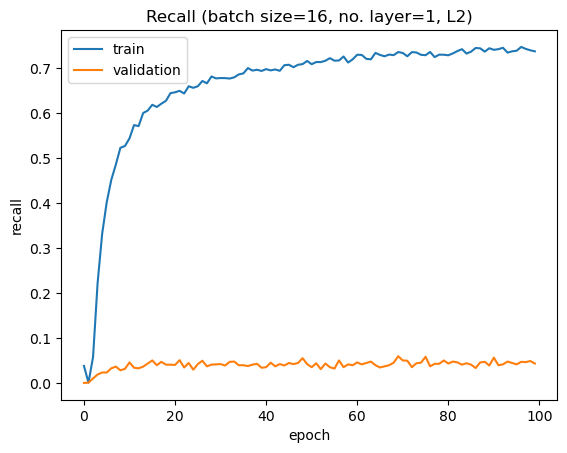

In [93]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [94]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.053
Training Accuracy: 0.935
Training Recall: 0.738


Validation Loss: 0.2
Validation Accuracy: 0.783
Validation Recall: 0.043


### batch size = 32, number of layer = 1

In [95]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1785 - accuracy: 0.7668 - recall_19: 0.1036 - val_loss: 0.1449 - val_accuracy: 0.8331 - val_recall_19: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1357 - accuracy: 0.8333 - recall_19: 0.0000e+00 - val_loss: 0.1466 - val_accuracy: 0.8330 - val_recall_19: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1321 - accuracy: 0.8331 - recall_19: 0.0025 - val_loss: 0.1517 - val_accuracy: 0.8304 - val_recall_19: 6.2500e-04 - 2s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1278 - accuracy: 0.8336 - recall_19: 0.0289 - val_loss: 0.1594 - val_accuracy: 0.8193 - val_recall_19: 0.0044 - 2s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1224 - accuracy: 0.8377 - recall_19: 0.0870 - val_loss: 0.1644 - val_accuracy: 0.8130 - val_recall_19: 0.0050 - 2s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1181 - accuracy: 0.8429 - recall_19: 0.1561 - val_loss: 0.1737 - val_accuracy: 0.7975 - val_recall_19:

Epoch 50/100
1200/1200 - 2s - loss: 0.0653 - accuracy: 0.9221 - recall_19: 0.6694 - val_loss: 0.2539 - val_accuracy: 0.7190 - val_recall_19: 0.0831 - 2s/epoch - 1ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.0657 - accuracy: 0.9210 - recall_19: 0.6652 - val_loss: 0.2539 - val_accuracy: 0.7189 - val_recall_19: 0.0806 - 2s/epoch - 1ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.0639 - accuracy: 0.9244 - recall_19: 0.6777 - val_loss: 0.2540 - val_accuracy: 0.7183 - val_recall_19: 0.0838 - 2s/epoch - 1ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.0646 - accuracy: 0.9228 - recall_19: 0.6725 - val_loss: 0.2495 - val_accuracy: 0.7249 - val_recall_19: 0.0737 - 2s/epoch - 1ms/step
Epoch 54/100
1200/1200 - 2s - loss: 0.0647 - accuracy: 0.9227 - recall_19: 0.6737 - val_loss: 0.2579 - val_accuracy: 0.7152 - val_recall_19: 0.0850 - 2s/epoch - 1ms/step
Epoch 55/100
1200/1200 - 2s - loss: 0.0631 - accuracy: 0.9253 - recall_19: 0.6808 - val_loss: 0.2542 - val_accuracy: 0.7199 - val_recall_19: 0.0775 - 

Epoch 99/100
1200/1200 - 2s - loss: 0.0574 - accuracy: 0.9325 - recall_19: 0.7067 - val_loss: 0.2575 - val_accuracy: 0.7226 - val_recall_19: 0.0875 - 2s/epoch - 2ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.0563 - accuracy: 0.9353 - recall_19: 0.7147 - val_loss: 0.2569 - val_accuracy: 0.7214 - val_recall_19: 0.0794 - 2s/epoch - 1ms/step


#### Predict

In [96]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

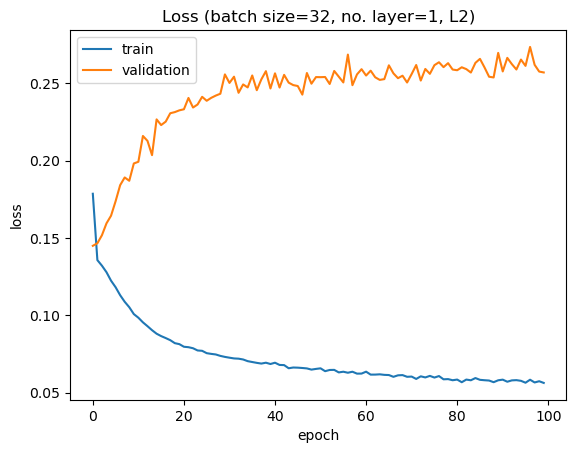

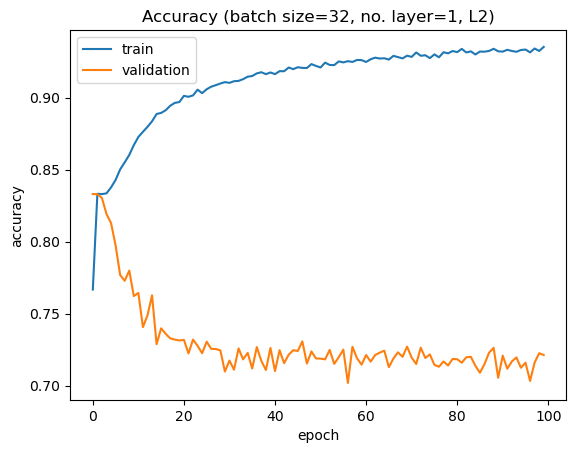

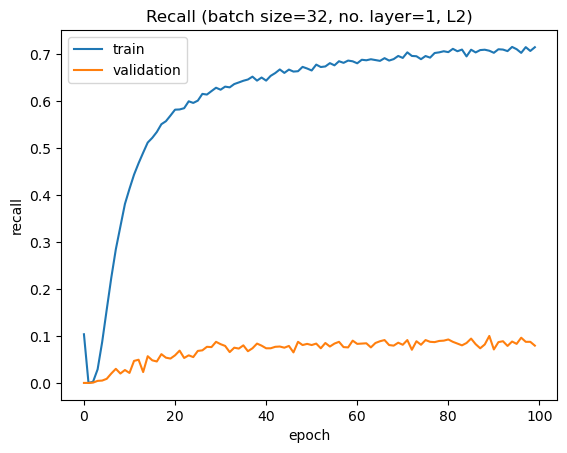

In [97]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [98]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.056
Training Accuracy: 0.935
Training Recall: 0.715


Validation Loss: 0.257
Validation Accuracy: 0.721
Validation Recall: 0.079


### batch size = 64, number of layer = 1

In [99]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2017 - accuracy: 0.7701 - recall_20: 0.1117 - val_loss: 0.1640 - val_accuracy: 0.8309 - val_recall_20: 0.0025 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1385 - accuracy: 0.8330 - recall_20: 0.0033 - val_loss: 0.1495 - val_accuracy: 0.8327 - val_recall_20: 0.0000e+00 - 808ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1276 - accuracy: 0.8345 - recall_20: 0.0225 - val_loss: 0.1574 - val_accuracy: 0.8255 - val_recall_20: 0.0019 - 827ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1213 - accuracy: 0.8385 - recall_20: 0.0859 - val_loss: 0.1771 - val_accuracy: 0.7878 - val_recall_20: 0.0169 - 838ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1136 - accuracy: 0.8486 - recall_20: 0.1897 - val_loss: 0.1748 - val_accuracy: 0.7978 - val_recall_20: 0.0175 - 809ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1054 - accuracy: 0.8623 - recall_20: 0.3067 - val_loss: 0.1870 - val_accuracy: 0.7808 - val_recall_20: 0.0306 - 81

Epoch 49/100
600/600 - 1s - loss: 0.0453 - accuracy: 0.9476 - recall_20: 0.7636 - val_loss: 0.2595 - val_accuracy: 0.7201 - val_recall_20: 0.0594 - 838ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.0432 - accuracy: 0.9513 - recall_20: 0.7755 - val_loss: 0.2562 - val_accuracy: 0.7262 - val_recall_20: 0.0606 - 781ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0442 - accuracy: 0.9499 - recall_20: 0.7702 - val_loss: 0.2596 - val_accuracy: 0.7212 - val_recall_20: 0.0650 - 781ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0457 - accuracy: 0.9473 - recall_20: 0.7597 - val_loss: 0.2601 - val_accuracy: 0.7216 - val_recall_20: 0.0650 - 850ms/epoch - 1ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0430 - accuracy: 0.9521 - recall_20: 0.7775 - val_loss: 0.2689 - val_accuracy: 0.7116 - val_recall_20: 0.0725 - 789ms/epoch - 1ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0427 - accuracy: 0.9521 - recall_20: 0.7784 - val_loss: 0.2683 - val_accuracy: 0.7107 - val_recall_20: 0.0819

Epoch 97/100
600/600 - 1s - loss: 0.0377 - accuracy: 0.9589 - recall_20: 0.7994 - val_loss: 0.2630 - val_accuracy: 0.7212 - val_recall_20: 0.0800 - 819ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.0377 - accuracy: 0.9590 - recall_20: 0.8041 - val_loss: 0.2645 - val_accuracy: 0.7201 - val_recall_20: 0.0744 - 820ms/epoch - 1ms/step
Epoch 99/100
600/600 - 1s - loss: 0.0374 - accuracy: 0.9590 - recall_20: 0.8009 - val_loss: 0.2602 - val_accuracy: 0.7249 - val_recall_20: 0.0669 - 818ms/epoch - 1ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0380 - accuracy: 0.9582 - recall_20: 0.7997 - val_loss: 0.2705 - val_accuracy: 0.7129 - val_recall_20: 0.0737 - 836ms/epoch - 1ms/step


#### Predict

In [100]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

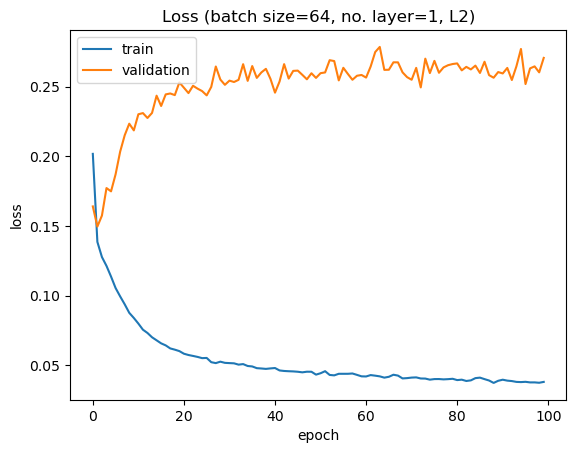

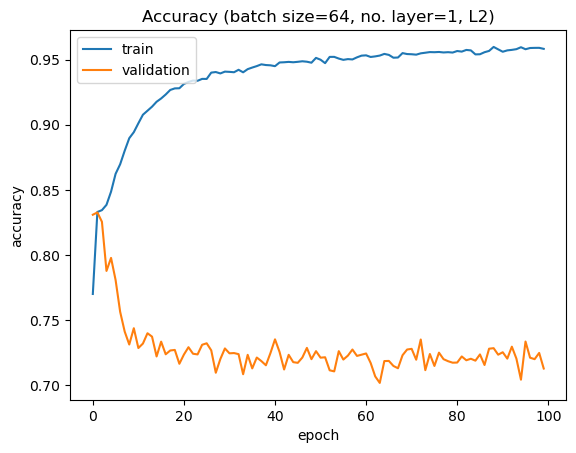

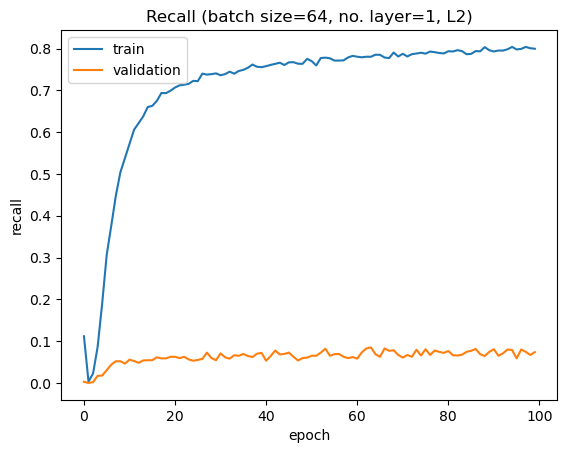

In [101]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [102]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.038
Training Accuracy: 0.958
Training Recall: 0.8


Validation Loss: 0.271
Validation Accuracy: 0.713


### batch size = 16, number of layer = 2

In [103]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),
        
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model

def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\vgg_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\vgg_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [104]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 3s - loss: 0.1637 - accuracy: 0.7877 - recall_21: 0.0669 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 2/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy:

Epoch 48/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 49/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 50/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 53/100
2400/2400 - 3s - loss: 0.1389 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1389 - val

2400/2400 - 3s - loss: 0.1385 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1397 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 95/100
2400/2400 - 3s - loss: 0.1384 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 96/100
2400/2400 - 3s - loss: 0.1386 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 97/100
2400/2400 - 3s - loss: 0.1385 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 98/100
2400/2400 - 3s - loss: 0.1385 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_21: 0.0000e+00 - 3s/epoch - 1ms/step
Epoch 99/100
2400/2400 - 3s - loss: 0.1385 - accuracy: 0.8333 - recall_21: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.

#### Predict

In [105]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

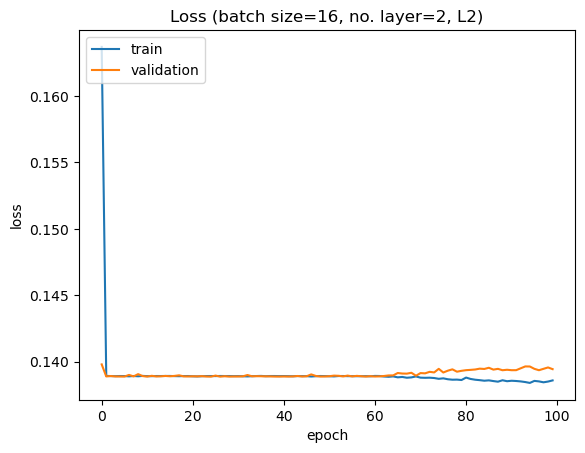

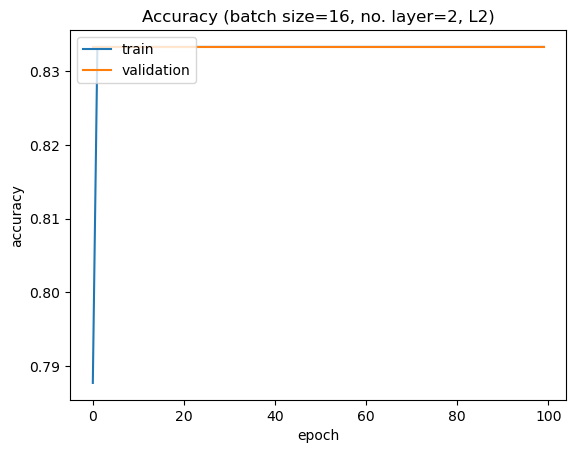

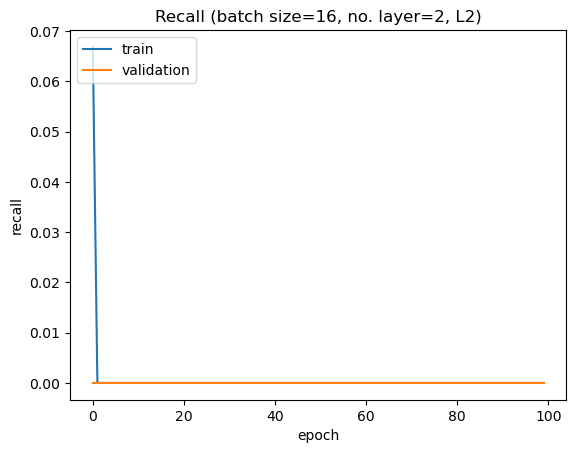

In [106]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [107]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [108]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1753 - accuracy: 0.8122 - recall_22: 0.0406 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1390 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 3/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 4/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 5/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 6/100
1200/1200 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1390 - val_accuracy:

Epoch 48/100
1200/1200 - 1s - loss: 0.1382 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1400 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 49/100
1200/1200 - 1s - loss: 0.1382 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1401 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 50/100
1200/1200 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1401 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 51/100
1200/1200 - 1s - loss: 0.1381 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1400 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 52/100
1200/1200 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1402 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 53/100
1200/1200 - 1s - loss: 0.1382 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1402 - val

1200/1200 - 2s - loss: 0.1378 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 95/100
1200/1200 - 1s - loss: 0.1377 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 96/100
1200/1200 - 1s - loss: 0.1376 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 97/100
1200/1200 - 2s - loss: 0.1377 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 2s/epoch - 1ms/step
Epoch 98/100
1200/1200 - 1s - loss: 0.1376 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_22: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 99/100
1200/1200 - 1s - loss: 0.1377 - accuracy: 0.8333 - recall_22: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.

#### Predict

In [109]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

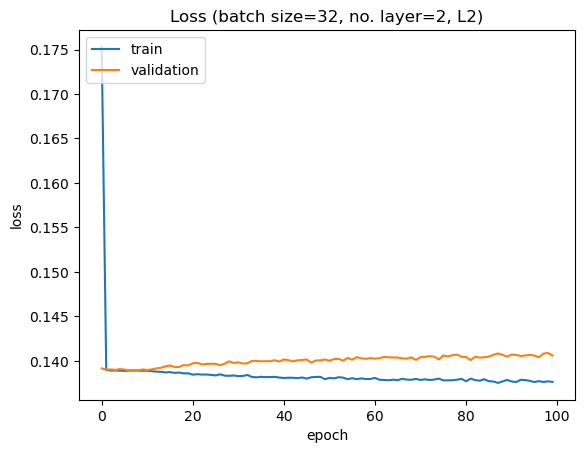

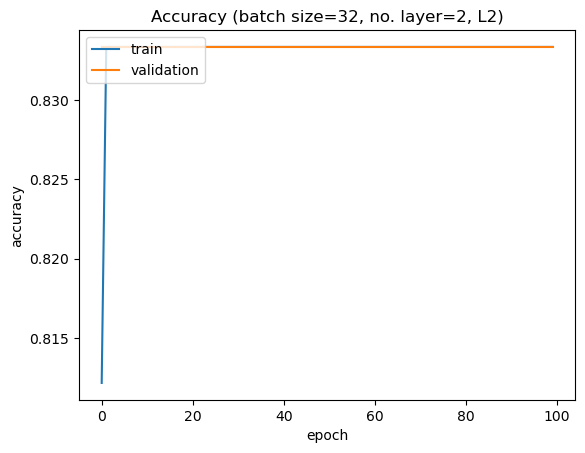

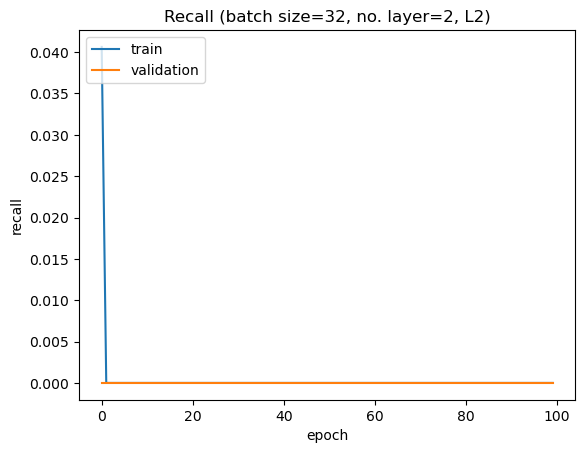

In [110]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [111]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.141
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [112]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2038 - accuracy: 0.7838 - recall_23: 0.0794 - val_loss: 0.1940 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1443 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1398 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 825ms/epoch - 1ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 774ms/epoch - 1ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 806ms/epoch - 1ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 807ms/epoch - 1ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1390 - val_accuracy:

Epoch 47/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 771ms/epoch - 1ms/step
Epoch 48/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 788ms/epoch - 1ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 806ms/epoch - 1ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 866ms/epoch - 1ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 850ms/epoch - 1ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1389 - 

Epoch 93/100
600/600 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 820ms/epoch - 1ms/step
Epoch 94/100
600/600 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1404 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 790ms/epoch - 1ms/step
Epoch 95/100
600/600 - 1s - loss: 0.1380 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 850ms/epoch - 1ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 822ms/epoch - 1ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.8333 - val_recall_23: 0.0000e+00 - 820ms/epoch - 1ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1379 - accuracy: 0.8333 - recall_23: 0.0000e+00 - val_loss: 0.1407 - 

#### Predict

In [113]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\vgg_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

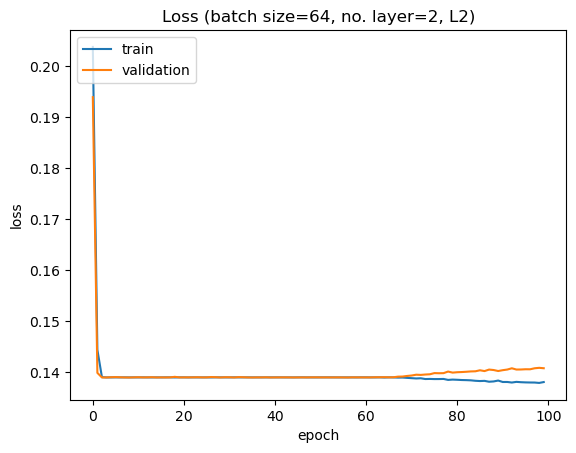

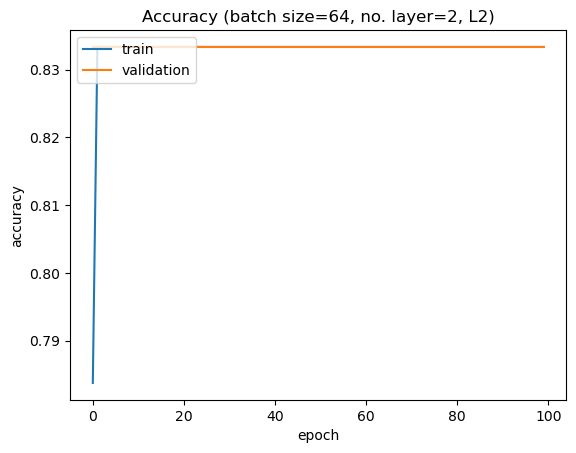

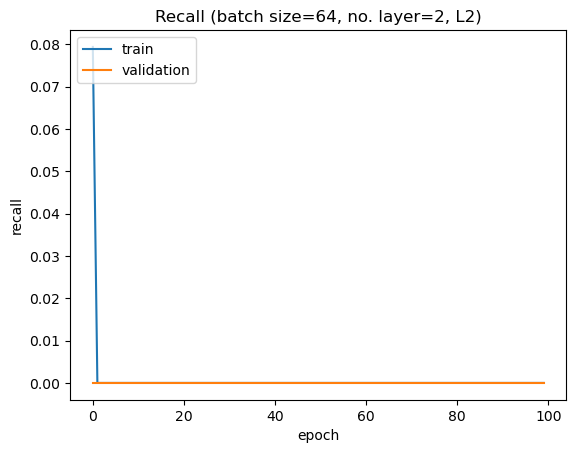

In [114]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [115]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.138
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.141
Validation Accuracy: 0.833
Validation Recall: 0.0


## resnet

In [116]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

left_train = np.load('resnet_train_left.npy')
left_train_augmented = np.load('AUG_resnet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('resnet_train_right.npy')
left_test = np.load('resnet_test_left.npy')
right_test = np.load('resnet_test_right.npy')

# left_train = np.load('densenet_train_left.npy')
# left_train_augmented = np.load('AUG_densenet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('densenet_train_right.npy')
# left_test = np.load('densenet_test_left.npy')
# right_test = np.load('densenet_test_right.npy')

In [117]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [118]:
# input_shape = (512,)
input_shape = (2048,)
# input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\resnet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\resnet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [119]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 6s - loss: 0.1629 - accuracy: 0.7892 - recall_24: 0.0708 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00 - 6s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 5s - loss: 0.1354 - accuracy: 0.8333 - recall_24: 0.0000e+00 - val_loss: 0.1445 - val_accuracy: 0.8333 - val_recall_24: 0.0000e+00 - 5s/epoch - 2ms/step
Epoch 3/100
2400/2400 - 5s - loss: 0.1267 - accuracy: 0.8342 - recall_24: 0.0216 - val_loss: 0.1562 - val_accuracy: 0.8241 - val_recall_24: 0.0031 - 5s/epoch - 2ms/step
Epoch 4/100
2400/2400 - 5s - loss: 0.1107 - accuracy: 0.8517 - recall_24: 0.2355 - val_loss: 0.1647 - val_accuracy: 0.8127 - val_recall_24: 0.0225 - 5s/epoch - 2ms/step
Epoch 5/100
2400/2400 - 5s - loss: 0.0972 - accuracy: 0.8718 - recall_24: 0.3975 - val_loss: 0.1727 - val_accuracy: 0.7995 - val_recall_24: 0.0331 - 5s/epoch - 2ms/step
Epoch 6/100
2400/2400 - 5s - loss: 0.0868 - accuracy: 0.8851 - recall_24: 0.5005 - val_loss: 0.1772 - val_accuracy: 0.7935 - val_recall_24: 0.0

Epoch 50/100
2400/2400 - 5s - loss: 0.0360 - accuracy: 0.9561 - recall_24: 0.8439 - val_loss: 0.1919 - val_accuracy: 0.7899 - val_recall_24: 0.0550 - 5s/epoch - 2ms/step
Epoch 51/100
2400/2400 - 5s - loss: 0.0356 - accuracy: 0.9557 - recall_24: 0.8377 - val_loss: 0.1980 - val_accuracy: 0.7810 - val_recall_24: 0.0606 - 5s/epoch - 2ms/step
Epoch 52/100
2400/2400 - 5s - loss: 0.0346 - accuracy: 0.9569 - recall_24: 0.8413 - val_loss: 0.1986 - val_accuracy: 0.7797 - val_recall_24: 0.0556 - 5s/epoch - 2ms/step
Epoch 53/100
2400/2400 - 5s - loss: 0.0335 - accuracy: 0.9594 - recall_24: 0.8511 - val_loss: 0.1980 - val_accuracy: 0.7815 - val_recall_24: 0.0550 - 5s/epoch - 2ms/step
Epoch 54/100
2400/2400 - 5s - loss: 0.0346 - accuracy: 0.9579 - recall_24: 0.8492 - val_loss: 0.1968 - val_accuracy: 0.7837 - val_recall_24: 0.0562 - 5s/epoch - 2ms/step
Epoch 55/100
2400/2400 - 5s - loss: 0.0342 - accuracy: 0.9580 - recall_24: 0.8502 - val_loss: 0.1953 - val_accuracy: 0.7864 - val_recall_24: 0.0531 - 

Epoch 99/100
2400/2400 - 5s - loss: 0.0298 - accuracy: 0.9633 - recall_24: 0.8694 - val_loss: 0.1969 - val_accuracy: 0.7876 - val_recall_24: 0.0538 - 5s/epoch - 2ms/step
Epoch 100/100
2400/2400 - 5s - loss: 0.0284 - accuracy: 0.9657 - recall_24: 0.8775 - val_loss: 0.1958 - val_accuracy: 0.7882 - val_recall_24: 0.0487 - 5s/epoch - 2ms/step


#### Predict

In [120]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

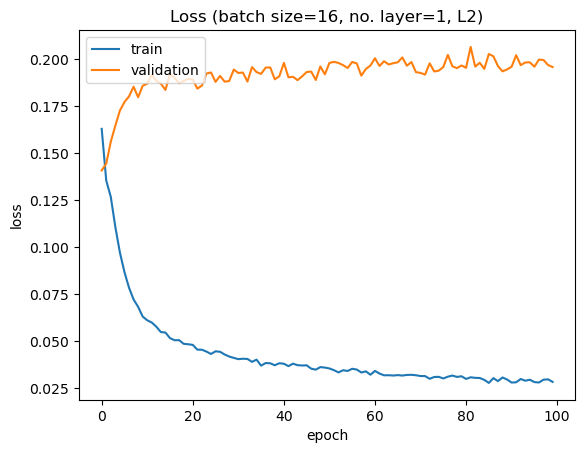

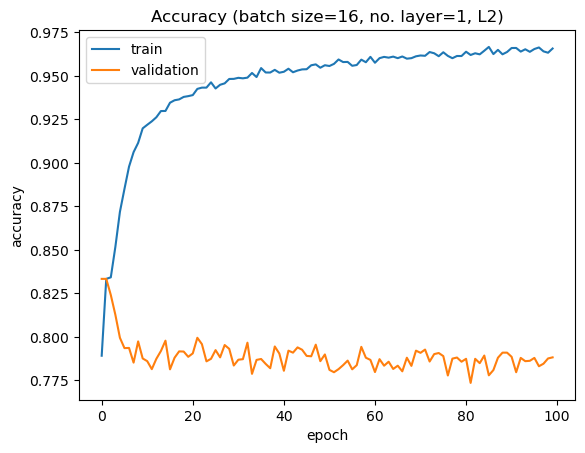

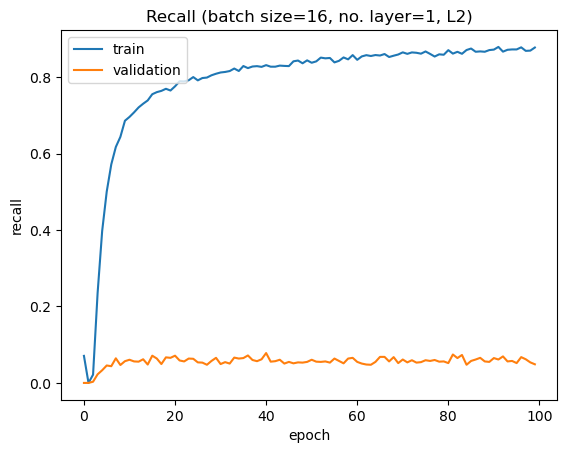

In [121]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [122]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.028
Training Accuracy: 0.966
Training Recall: 0.877


Validation Loss: 0.196
Validation Accuracy: 0.788
Validation Recall: 0.049


### batch size = 32, number of layer = 1

In [123]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1803 - accuracy: 0.7573 - recall_25: 0.1234 - val_loss: 0.1449 - val_accuracy: 0.8333 - val_recall_25: 0.0000e+00 - 3s/epoch - 3ms/step
Epoch 2/100
1200/1200 - 3s - loss: 0.1332 - accuracy: 0.8334 - recall_25: 3.1250e-04 - val_loss: 0.1481 - val_accuracy: 0.8333 - val_recall_25: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1189 - accuracy: 0.8445 - recall_25: 0.1108 - val_loss: 0.1651 - val_accuracy: 0.8105 - val_recall_25: 0.0200 - 2s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.0988 - accuracy: 0.8714 - recall_25: 0.3630 - val_loss: 0.1717 - val_accuracy: 0.8079 - val_recall_25: 0.0213 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.0811 - accuracy: 0.8964 - recall_25: 0.5348 - val_loss: 0.1841 - val_accuracy: 0.7845 - val_recall_25: 0.0325 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.0671 - accuracy: 0.9158 - recall_25: 0.6453 - val_loss: 0.1860 - val_accuracy: 0.7849 - val_recall_25: 0.0

Epoch 50/100
1200/1200 - 2s - loss: 0.0191 - accuracy: 0.9780 - recall_25: 0.9045 - val_loss: 0.1975 - val_accuracy: 0.7890 - val_recall_25: 0.0362 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.0219 - accuracy: 0.9747 - recall_25: 0.8956 - val_loss: 0.1941 - val_accuracy: 0.7957 - val_recall_25: 0.0362 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.0206 - accuracy: 0.9761 - recall_25: 0.8986 - val_loss: 0.2025 - val_accuracy: 0.7825 - val_recall_25: 0.0394 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.0202 - accuracy: 0.9766 - recall_25: 0.9020 - val_loss: 0.2005 - val_accuracy: 0.7859 - val_recall_25: 0.0450 - 2s/epoch - 2ms/step
Epoch 54/100
1200/1200 - 2s - loss: 0.0207 - accuracy: 0.9760 - recall_25: 0.8973 - val_loss: 0.1943 - val_accuracy: 0.7929 - val_recall_25: 0.0362 - 2s/epoch - 2ms/step
Epoch 55/100
1200/1200 - 2s - loss: 0.0207 - accuracy: 0.9758 - recall_25: 0.8963 - val_loss: 0.1948 - val_accuracy: 0.7918 - val_recall_25: 0.0394 - 

Epoch 99/100
1200/1200 - 2s - loss: 0.0162 - accuracy: 0.9819 - recall_25: 0.9177 - val_loss: 0.1983 - val_accuracy: 0.7887 - val_recall_25: 0.0381 - 2s/epoch - 2ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.0167 - accuracy: 0.9815 - recall_25: 0.9173 - val_loss: 0.2027 - val_accuracy: 0.7849 - val_recall_25: 0.0400 - 2s/epoch - 2ms/step


#### Predict

In [124]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

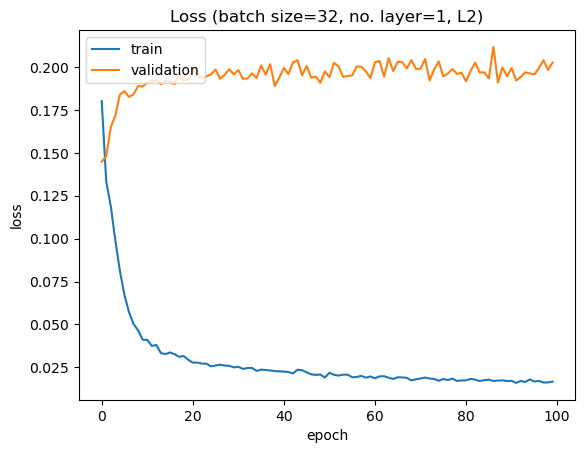

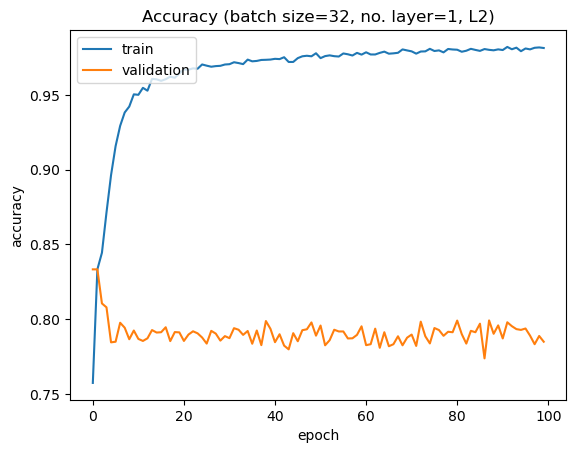

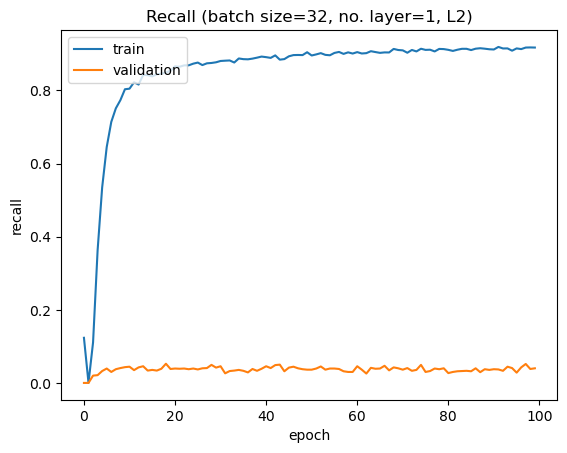

In [125]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [126]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.017
Training Accuracy: 0.982
Training Recall: 0.917


Validation Loss: 0.203
Validation Accuracy: 0.785
Validation Recall: 0.04


### batch size = 64, number of layer = 1

In [127]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2030 - accuracy: 0.7609 - recall_26: 0.1233 - val_loss: 0.1690 - val_accuracy: 0.8333 - val_recall_26: 0.0000e+00 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1392 - accuracy: 0.8333 - recall_26: 0.0000e+00 - val_loss: 0.1487 - val_accuracy: 0.8333 - val_recall_26: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 2s - loss: 0.1182 - accuracy: 0.8401 - recall_26: 0.0758 - val_loss: 0.1587 - val_accuracy: 0.8266 - val_recall_26: 0.0056 - 2s/epoch - 3ms/step
Epoch 4/100
600/600 - 2s - loss: 0.0948 - accuracy: 0.8774 - recall_26: 0.3784 - val_loss: 0.1727 - val_accuracy: 0.7966 - val_recall_26: 0.0256 - 2s/epoch - 3ms/step
Epoch 5/100
600/600 - 2s - loss: 0.0760 - accuracy: 0.9056 - recall_26: 0.5800 - val_loss: 0.1762 - val_accuracy: 0.8006 - val_recall_26: 0.0244 - 2s/epoch - 3ms/step
Epoch 6/100
600/600 - 1s - loss: 0.0619 - accuracy: 0.9240 - recall_26: 0.6858 - val_loss: 0.1811 - val_accuracy: 0.7903 - val_recall_26: 0.0300 - 1s/epo

Epoch 50/100
600/600 - 2s - loss: 0.0165 - accuracy: 0.9809 - recall_26: 0.9181 - val_loss: 0.2057 - val_accuracy: 0.7794 - val_recall_26: 0.0437 - 2s/epoch - 3ms/step
Epoch 51/100
600/600 - 2s - loss: 0.0169 - accuracy: 0.9809 - recall_26: 0.9162 - val_loss: 0.2074 - val_accuracy: 0.7786 - val_recall_26: 0.0381 - 2s/epoch - 3ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0156 - accuracy: 0.9824 - recall_26: 0.9197 - val_loss: 0.1987 - val_accuracy: 0.7893 - val_recall_26: 0.0331 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0169 - accuracy: 0.9805 - recall_26: 0.9134 - val_loss: 0.2021 - val_accuracy: 0.7866 - val_recall_26: 0.0388 - 1s/epoch - 2ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0161 - accuracy: 0.9818 - recall_26: 0.9216 - val_loss: 0.1958 - val_accuracy: 0.7920 - val_recall_26: 0.0406 - 1s/epoch - 2ms/step
Epoch 55/100
600/600 - 1s - loss: 0.0171 - accuracy: 0.9804 - recall_26: 0.9142 - val_loss: 0.2001 - val_accuracy: 0.7884 - val_recall_26: 0.0306 - 1s/epoch - 2

Epoch 99/100
600/600 - 2s - loss: 0.0135 - accuracy: 0.9851 - recall_26: 0.9286 - val_loss: 0.2000 - val_accuracy: 0.7909 - val_recall_26: 0.0381 - 2s/epoch - 3ms/step
Epoch 100/100
600/600 - 2s - loss: 0.0135 - accuracy: 0.9853 - recall_26: 0.9295 - val_loss: 0.2019 - val_accuracy: 0.7867 - val_recall_26: 0.0369 - 2s/epoch - 3ms/step


#### Predict

In [128]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

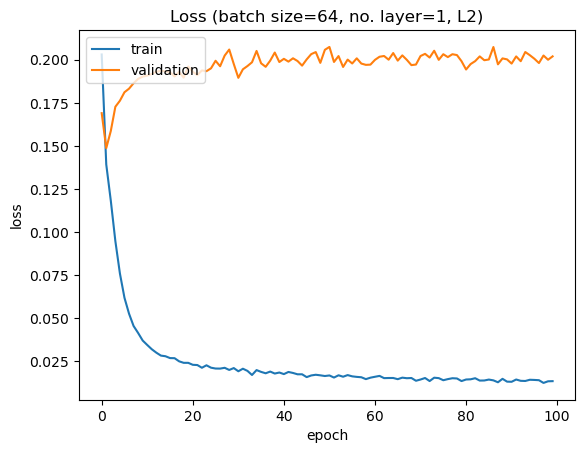

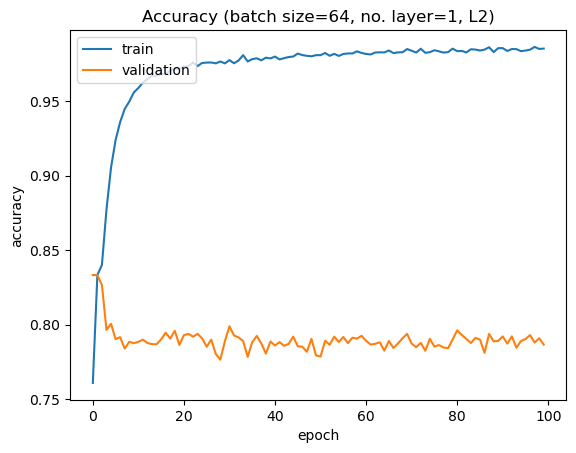

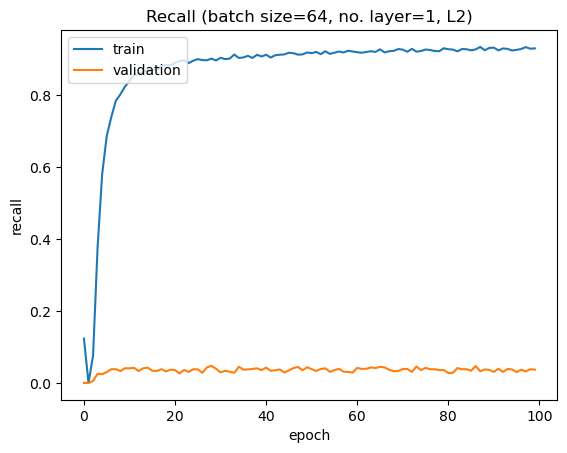

In [129]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [130]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.014
Training Accuracy: 0.985
Training Recall: 0.93


Validation Loss: 0.202
Validation Accuracy: 0.787
Validation Recall: 0.037


### batch size = 16, number of layer = 2

In [131]:
def create_shared_network(input_shape):
    model = keras.Sequential([
        
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\resnet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\resnet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [132]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1640 - accuracy: 0.7885 - recall_27: 0.0670 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 5s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 3/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 4/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 5/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 6/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1389 - val_accuracy:

Epoch 48/100
2400/2400 - 4s - loss: 0.1387 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 49/100
2400/2400 - 4s - loss: 0.1387 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 50/100
2400/2400 - 4s - loss: 0.1386 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 51/100
2400/2400 - 4s - loss: 0.1387 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1396 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 52/100
2400/2400 - 4s - loss: 0.1387 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1395 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 53/100
2400/2400 - 4s - loss: 0.1385 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1397 - val

2400/2400 - 4s - loss: 0.1375 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1425 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 95/100
2400/2400 - 4s - loss: 0.1373 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1427 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 96/100
2400/2400 - 4s - loss: 0.1374 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 97/100
2400/2400 - 4s - loss: 0.1372 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 98/100
2400/2400 - 4s - loss: 0.1373 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.8333 - val_recall_27: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 99/100
2400/2400 - 4s - loss: 0.1374 - accuracy: 0.8333 - recall_27: 0.0000e+00 - val_loss: 0.1431 - val_accuracy: 0.

#### Predict

In [133]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

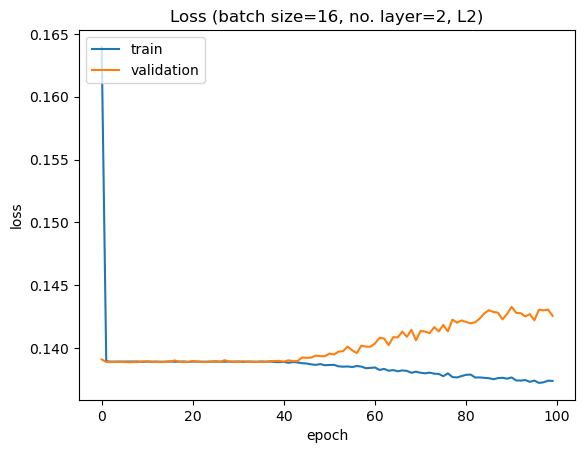

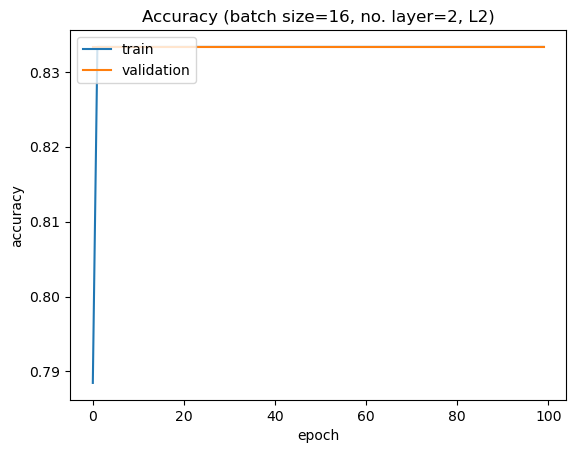

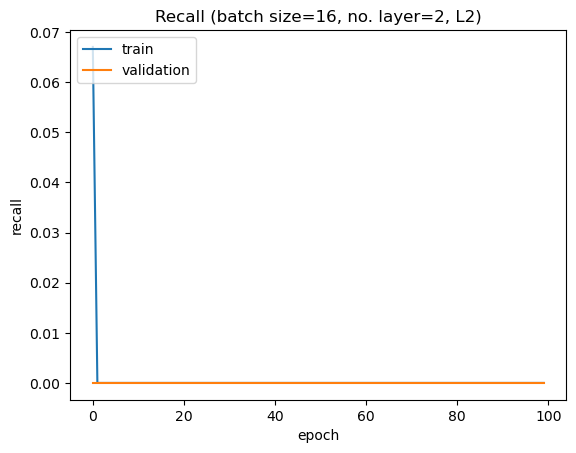

In [134]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [135]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.137
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.143
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [136]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1826 - accuracy: 0.7644 - recall_28: 0.1027 - val_loss: 0.1402 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 3s/epoch - 3ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1391 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1391 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1391 - val_accuracy:

Epoch 48/100
1200/1200 - 2s - loss: 0.1366 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1419 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 49/100
1200/1200 - 2s - loss: 0.1368 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1416 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 50/100
1200/1200 - 2s - loss: 0.1366 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.1368 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1420 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.1367 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1420 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.1361 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1425 - val

1200/1200 - 2s - loss: 0.1313 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1504 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 95/100
1200/1200 - 2s - loss: 0.1309 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1488 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 96/100
1200/1200 - 2s - loss: 0.1307 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1491 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 97/100
1200/1200 - 2s - loss: 0.1310 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1464 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 98/100
1200/1200 - 2s - loss: 0.1308 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1470 - val_accuracy: 0.8333 - val_recall_28: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 99/100
1200/1200 - 2s - loss: 0.1311 - accuracy: 0.8333 - recall_28: 0.0000e+00 - val_loss: 0.1467 - val_accuracy: 0.

#### Predict

In [137]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

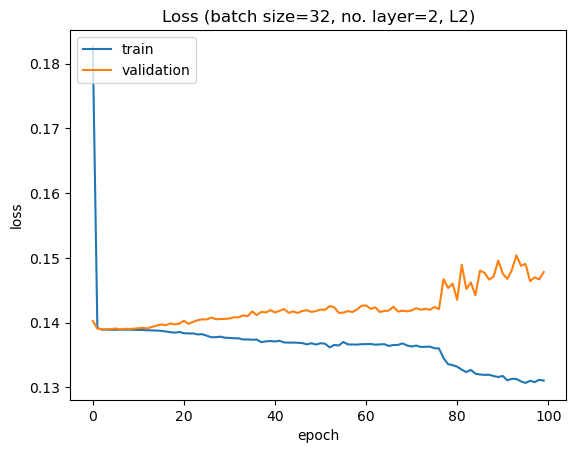

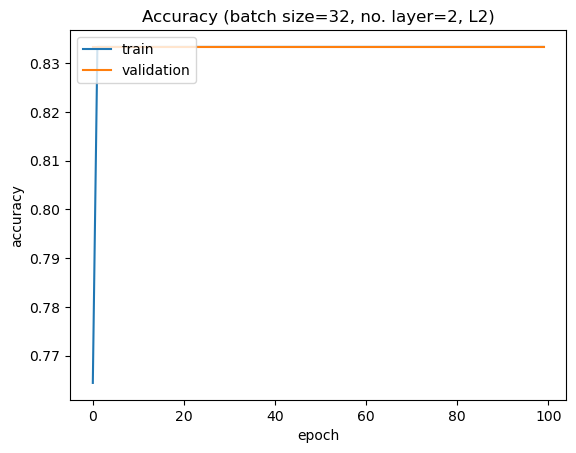

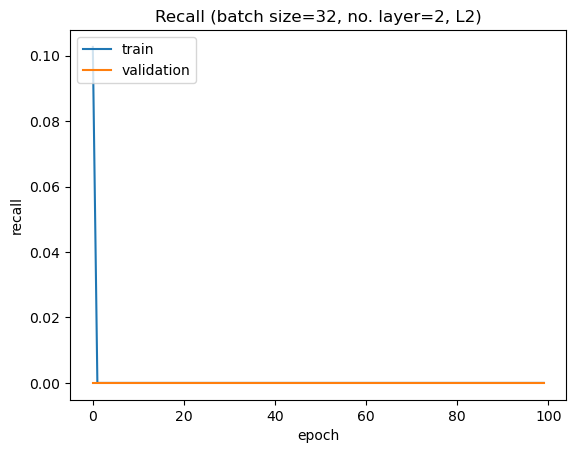

In [138]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [139]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.131
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.148
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [140]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2051 - accuracy: 0.7504 - recall_29: 0.1252 - val_loss: 0.2095 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 4ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1472 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1391 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - va

Epoch 48/100
600/600 - 2s - loss: 0.1326 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1528 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1326 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1530 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 50/100
600/600 - 2s - loss: 0.1323 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1534 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 51/100
600/600 - 2s - loss: 0.1323 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1539 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1322 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1539 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 53/100
600/600 - 2s - loss: 0.1319 - accuracy: 0.8333 - recall_29: 0.0000e+00 - val_loss: 0.1541 - val_accuracy: 0

Epoch 95/100
600/600 - 2s - loss: 0.1240 - accuracy: 0.8326 - recall_29: 0.0108 - val_loss: 0.1578 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 96/100
600/600 - 2s - loss: 0.1243 - accuracy: 0.8329 - recall_29: 0.0150 - val_loss: 0.1549 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1240 - accuracy: 0.8327 - recall_29: 0.0084 - val_loss: 0.1559 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1245 - accuracy: 0.8322 - recall_29: 0.0067 - val_loss: 0.1545 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 99/100
600/600 - 2s - loss: 0.1245 - accuracy: 0.8322 - recall_29: 0.0048 - val_loss: 0.1537 - val_accuracy: 0.8333 - val_recall_29: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 100/100
600/600 - 1s - loss: 0.1237 - accuracy: 0.8324 - recall_29: 0.0077 - val_loss: 0.1563 - val_accuracy: 0.8333 - val_recall_29: 

#### Predict

In [141]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\resnet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

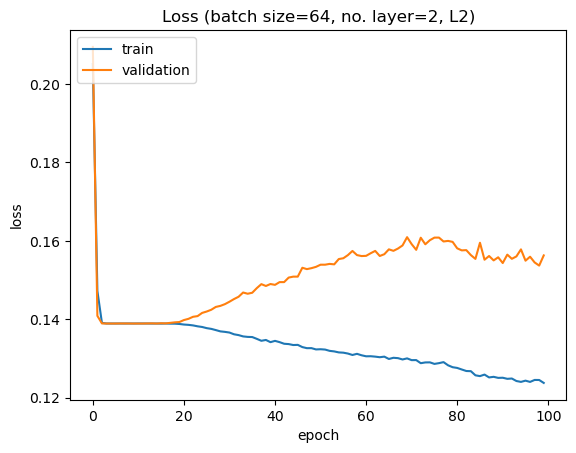

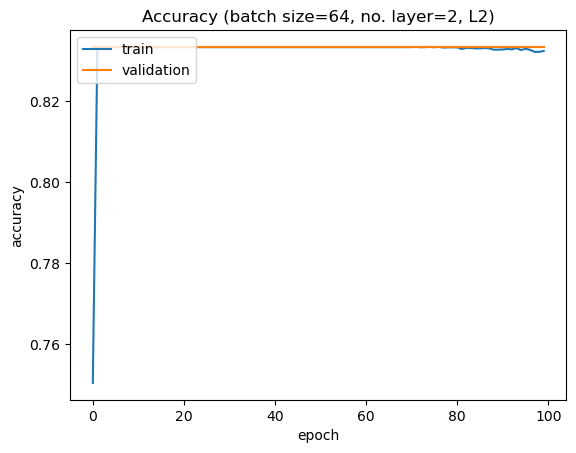

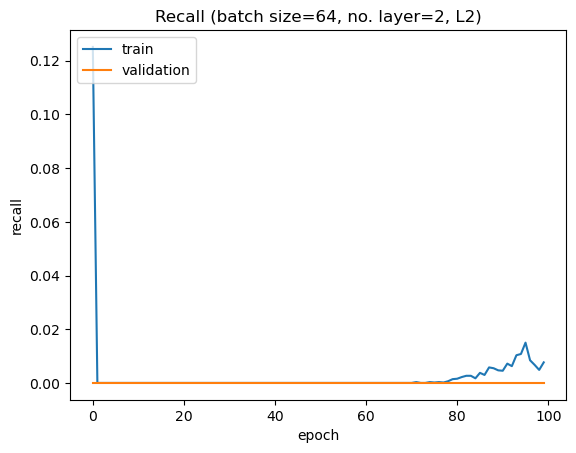

In [142]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [143]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.124
Training Accuracy: 0.832
Training Recall: 0.008


Validation Loss: 0.156
Validation Accuracy: 0.833
Validation Recall: 0.0


## densenet

In [144]:
# left_train = np.load('vgg_train_left.npy')
# left_train_augmented = np.load('AUG_vgg_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('vgg_train_right.npy')
# left_test = np.load('vgg_test_left.npy')
# right_test = np.load('vgg_test_right.npy')

# left_train = np.load('resnet_train_left.npy')
# left_train_augmented = np.load('AUG_resnet_train_left.npy')
# left_train = np.concatenate((left_train, left_train_augmented))
# right_train = np.load('resnet_train_right.npy')
# left_test = np.load('resnet_test_left.npy')
# right_test = np.load('resnet_test_right.npy')

left_train = np.load('densenet_train_left.npy')
left_train_augmented = np.load('AUG_densenet_train_left.npy')
left_train = np.concatenate((left_train, left_train_augmented))
right_train = np.load('densenet_train_right.npy')
left_test = np.load('densenet_test_left.npy')
right_test = np.load('densenet_test_right.npy')

In [145]:
left_array_dict = {}
right_array_dict = {}
for i in range(len(ground_truth)):
    left_array_dict[ground_truth['left'][i]] = left_train[i]
    if i%4 == 0:
        right_array_dict[ground_truth['right'][i//4]] = right_train[i//4]

pairs_for_training = []
for i in range(len(paired_data)):
    pairs_for_training.append([left_array_dict.get(paired_data[i][0]) , right_array_dict.get(paired_data[i][1])])
    
pairs_for_training = np.array(pairs_for_training)

left_images = pairs_for_training[:, 0]
right_images = pairs_for_training[:, 1]



test_candidates = pd.read_csv('.\COMP90086_2023_TLLdataset\\test_candidates.csv')

path = ".\COMP90086_2023_TLLdataset\\test\\left"
dir_list = os.listdir(path)
test_left_images_list = dir_list

path = ".\COMP90086_2023_TLLdataset\\test\\right"
dir_list = os.listdir(path)
test_right_images_list = dir_list

left_array_dict = {}
for i in range(len(test_left_images_list)):
    left_array_dict[test_left_images_list[i][:3]] = left_test[i]
    
right_array_dict = {}
for i in range(len(test_right_images_list)):
    right_array_dict[test_right_images_list[i][:3]] = right_test[i]
    
pairs_for_test = []
for j in range(len(test_candidates)):
    for i in range(20):
        pairs_for_test.append([left_array_dict.get(test_candidates.iloc[j][0]) , right_array_dict.get(test_candidates.iloc[j][i+1])])

pairs_for_test = np.array(pairs_for_test)

x_test_1 = pairs_for_test[:, 0]
x_test_2 = pairs_for_test[:, 1]

### batch size = 16, number of layer = 1

In [146]:
# input_shape = (512,)
# input_shape = (2048,)
input_shape = (1024,)

def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\densenet_{}_1_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\densenet_{}_1_{}.png".format(batch_size, metric))
    plt.show()

In [147]:
batch_size = 16
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 4s - loss: 0.1582 - accuracy: 0.8210 - recall_30: 0.0208 - val_loss: 0.1420 - val_accuracy: 0.8333 - val_recall_30: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 4s - loss: 0.1353 - accuracy: 0.8333 - recall_30: 0.0000e+00 - val_loss: 0.1482 - val_accuracy: 0.8328 - val_recall_30: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 3/100
2400/2400 - 4s - loss: 0.1311 - accuracy: 0.8333 - recall_30: 0.0025 - val_loss: 0.1549 - val_accuracy: 0.8283 - val_recall_30: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 4/100
2400/2400 - 4s - loss: 0.1274 - accuracy: 0.8328 - recall_30: 0.0256 - val_loss: 0.1604 - val_accuracy: 0.8226 - val_recall_30: 0.0037 - 4s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 4s - loss: 0.1244 - accuracy: 0.8344 - recall_30: 0.0562 - val_loss: 0.1644 - val_accuracy: 0.8138 - val_recall_30: 0.0088 - 4s/epoch - 2ms/step
Epoch 6/100
2400/2400 - 4s - loss: 0.1226 - accuracy: 0.8357 - recall_30: 0.0898 - val_loss: 0.1685 - val_accuracy: 0.8062 - val_recall_30:

Epoch 50/100
2400/2400 - 4s - loss: 0.0943 - accuracy: 0.8766 - recall_30: 0.4697 - val_loss: 0.2197 - val_accuracy: 0.7452 - val_recall_30: 0.0819 - 4s/epoch - 1ms/step
Epoch 51/100
2400/2400 - 4s - loss: 0.0945 - accuracy: 0.8763 - recall_30: 0.4673 - val_loss: 0.2173 - val_accuracy: 0.7466 - val_recall_30: 0.0763 - 4s/epoch - 1ms/step
Epoch 52/100
2400/2400 - 4s - loss: 0.0935 - accuracy: 0.8782 - recall_30: 0.4817 - val_loss: 0.2157 - val_accuracy: 0.7520 - val_recall_30: 0.0719 - 4s/epoch - 2ms/step
Epoch 53/100
2400/2400 - 4s - loss: 0.0934 - accuracy: 0.8779 - recall_30: 0.4716 - val_loss: 0.2239 - val_accuracy: 0.7355 - val_recall_30: 0.0775 - 4s/epoch - 2ms/step
Epoch 54/100
2400/2400 - 4s - loss: 0.0930 - accuracy: 0.8784 - recall_30: 0.4803 - val_loss: 0.2205 - val_accuracy: 0.7437 - val_recall_30: 0.0756 - 4s/epoch - 2ms/step
Epoch 55/100
2400/2400 - 4s - loss: 0.0922 - accuracy: 0.8814 - recall_30: 0.4906 - val_loss: 0.2219 - val_accuracy: 0.7429 - val_recall_30: 0.0794 - 

Epoch 99/100
2400/2400 - 4s - loss: 0.0864 - accuracy: 0.8903 - recall_30: 0.5356 - val_loss: 0.2287 - val_accuracy: 0.7387 - val_recall_30: 0.0850 - 4s/epoch - 2ms/step
Epoch 100/100
2400/2400 - 4s - loss: 0.0866 - accuracy: 0.8898 - recall_30: 0.5386 - val_loss: 0.2302 - val_accuracy: 0.7343 - val_recall_30: 0.0894 - 4s/epoch - 2ms/step


#### Predict

In [148]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

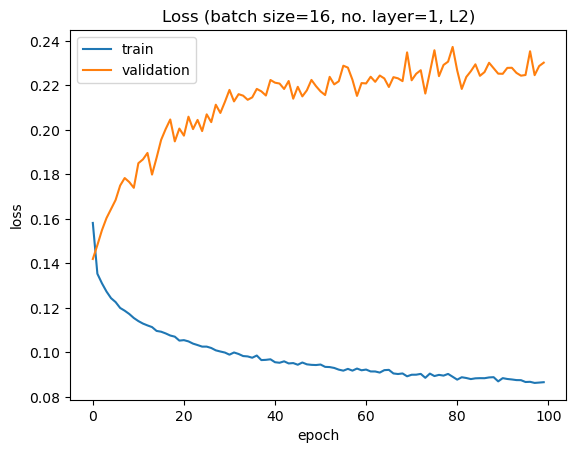

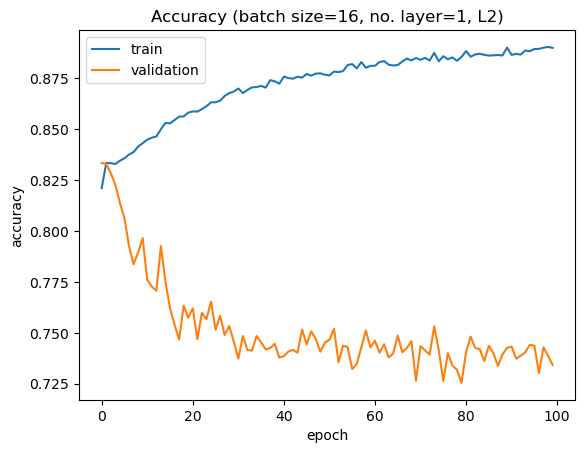

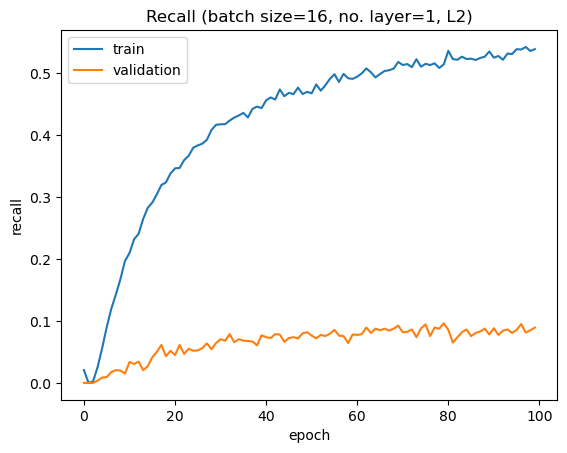

In [149]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [150]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.087
Training Accuracy: 0.89
Training Recall: 0.539


Validation Loss: 0.23
Validation Accuracy: 0.734
Validation Recall: 0.089


### batch size = 32, number of layer = 1

In [151]:
batch_size = 32
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 2s - loss: 0.1788 - accuracy: 0.7648 - recall_31: 0.1195 - val_loss: 0.1457 - val_accuracy: 0.8333 - val_recall_31: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1339 - accuracy: 0.8332 - recall_31: 1.5625e-04 - val_loss: 0.1520 - val_accuracy: 0.8313 - val_recall_31: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1290 - accuracy: 0.8340 - recall_31: 0.0194 - val_loss: 0.1607 - val_accuracy: 0.8209 - val_recall_31: 6.2500e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1216 - accuracy: 0.8387 - recall_31: 0.0939 - val_loss: 0.1663 - val_accuracy: 0.8145 - val_recall_31: 0.0031 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1144 - accuracy: 0.8476 - recall_31: 0.1933 - val_loss: 0.1764 - val_accuracy: 0.7981 - val_recall_31: 0.0119 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1074 - accuracy: 0.8590 - recall_31: 0.2941 - val_loss: 0.1855 - val_accuracy: 0.7782 - val_recall_31:

Epoch 50/100
1200/1200 - 2s - loss: 0.0522 - accuracy: 0.9398 - recall_31: 0.7305 - val_loss: 0.2369 - val_accuracy: 0.7425 - val_recall_31: 0.0613 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.0515 - accuracy: 0.9411 - recall_31: 0.7356 - val_loss: 0.2494 - val_accuracy: 0.7264 - val_recall_31: 0.0719 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.0523 - accuracy: 0.9398 - recall_31: 0.7295 - val_loss: 0.2439 - val_accuracy: 0.7356 - val_recall_31: 0.0712 - 2s/epoch - 1ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.0515 - accuracy: 0.9408 - recall_31: 0.7380 - val_loss: 0.2460 - val_accuracy: 0.7326 - val_recall_31: 0.0806 - 2s/epoch - 2ms/step
Epoch 54/100
1200/1200 - 2s - loss: 0.0510 - accuracy: 0.9411 - recall_31: 0.7348 - val_loss: 0.2348 - val_accuracy: 0.7462 - val_recall_31: 0.0613 - 2s/epoch - 1ms/step
Epoch 55/100
1200/1200 - 2s - loss: 0.0512 - accuracy: 0.9404 - recall_31: 0.7314 - val_loss: 0.2361 - val_accuracy: 0.7442 - val_recall_31: 0.0619 - 

Epoch 99/100
1200/1200 - 2s - loss: 0.0454 - accuracy: 0.9495 - recall_31: 0.7620 - val_loss: 0.2483 - val_accuracy: 0.7349 - val_recall_31: 0.0856 - 2s/epoch - 2ms/step
Epoch 100/100
1200/1200 - 2s - loss: 0.0460 - accuracy: 0.9487 - recall_31: 0.7589 - val_loss: 0.2451 - val_accuracy: 0.7389 - val_recall_31: 0.0819 - 2s/epoch - 2ms/step


#### Predict

In [152]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

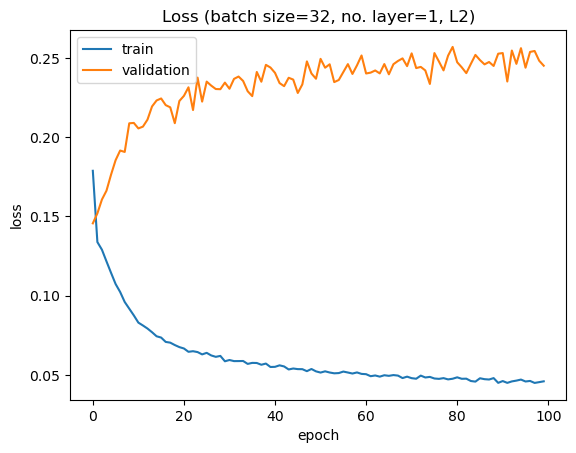

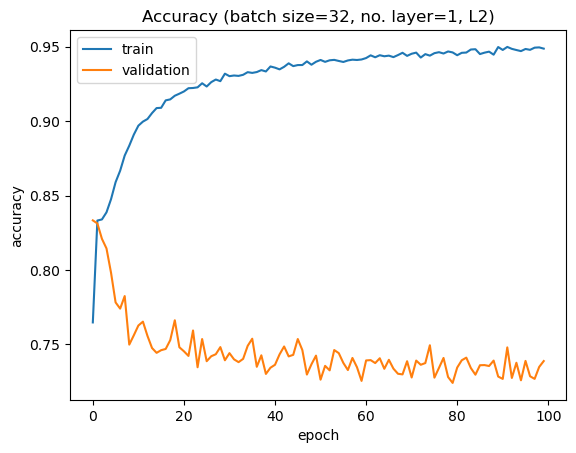

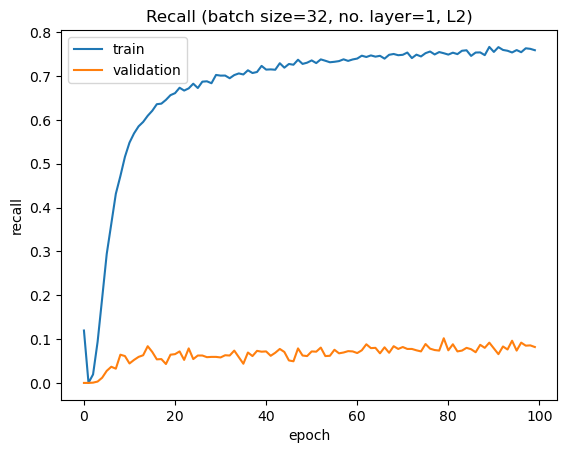

In [153]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [154]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.046
Training Accuracy: 0.949
Training Recall: 0.759


Validation Loss: 0.245
Validation Accuracy: 0.739
Validation Recall: 0.082


### batch size = 64, number of layer = 1

In [155]:
batch_size = 64
no_layer = 1

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2101 - accuracy: 0.7146 - recall_32: 0.2042 - val_loss: 0.1579 - val_accuracy: 0.8168 - val_recall_32: 0.0094 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1416 - accuracy: 0.8249 - recall_32: 0.0214 - val_loss: 0.1457 - val_accuracy: 0.8329 - val_recall_32: 0.0000e+00 - 998ms/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1314 - accuracy: 0.8330 - recall_32: 0.0041 - val_loss: 0.1540 - val_accuracy: 0.8285 - val_recall_32: 0.0031 - 1s/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1273 - accuracy: 0.8352 - recall_32: 0.0302 - val_loss: 0.1648 - val_accuracy: 0.8093 - val_recall_32: 0.0169 - 948ms/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1223 - accuracy: 0.8402 - recall_32: 0.0934 - val_loss: 0.1694 - val_accuracy: 0.8037 - val_recall_32: 0.0169 - 916ms/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1175 - accuracy: 0.8465 - recall_32: 0.1619 - val_loss: 0.1743 - val_accuracy: 0.7936 - val_recall_32: 0.0188 - 1s/ep

Epoch 50/100
600/600 - 1s - loss: 0.0628 - accuracy: 0.9285 - recall_32: 0.6797 - val_loss: 0.2478 - val_accuracy: 0.7312 - val_recall_32: 0.0825 - 912ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.0613 - accuracy: 0.9305 - recall_32: 0.6830 - val_loss: 0.2369 - val_accuracy: 0.7441 - val_recall_32: 0.0756 - 960ms/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.0617 - accuracy: 0.9296 - recall_32: 0.6823 - val_loss: 0.2404 - val_accuracy: 0.7382 - val_recall_32: 0.0725 - 943ms/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.0619 - accuracy: 0.9295 - recall_32: 0.6820 - val_loss: 0.2381 - val_accuracy: 0.7409 - val_recall_32: 0.0756 - 1s/epoch - 2ms/step
Epoch 54/100
600/600 - 1s - loss: 0.0610 - accuracy: 0.9307 - recall_32: 0.6780 - val_loss: 0.2473 - val_accuracy: 0.7310 - val_recall_32: 0.0763 - 994ms/epoch - 2ms/step
Epoch 55/100
600/600 - 1s - loss: 0.0617 - accuracy: 0.9303 - recall_32: 0.6872 - val_loss: 0.2401 - val_accuracy: 0.7403 - val_recall_32: 0.0706 - 

Epoch 99/100
600/600 - 1s - loss: 0.0546 - accuracy: 0.9394 - recall_32: 0.7144 - val_loss: 0.2510 - val_accuracy: 0.7327 - val_recall_32: 0.0956 - 980ms/epoch - 2ms/step
Epoch 100/100
600/600 - 1s - loss: 0.0541 - accuracy: 0.9396 - recall_32: 0.7142 - val_loss: 0.2528 - val_accuracy: 0.7301 - val_recall_32: 0.0969 - 1s/epoch - 2ms/step


#### Predict

In [156]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

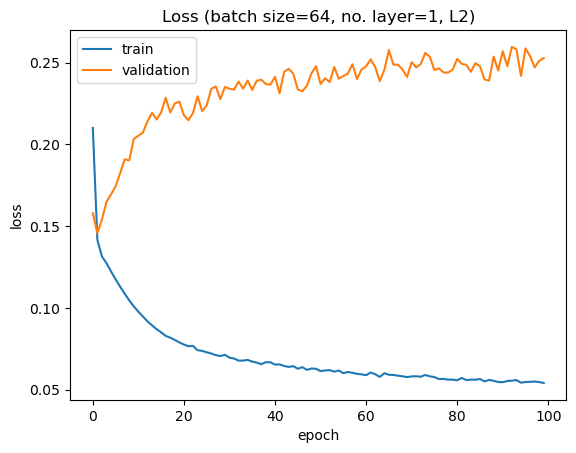

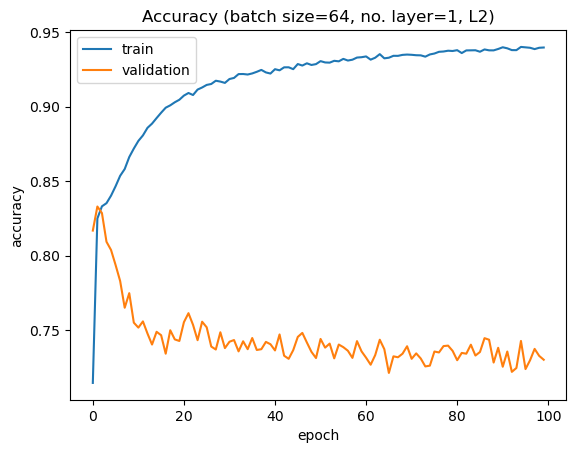

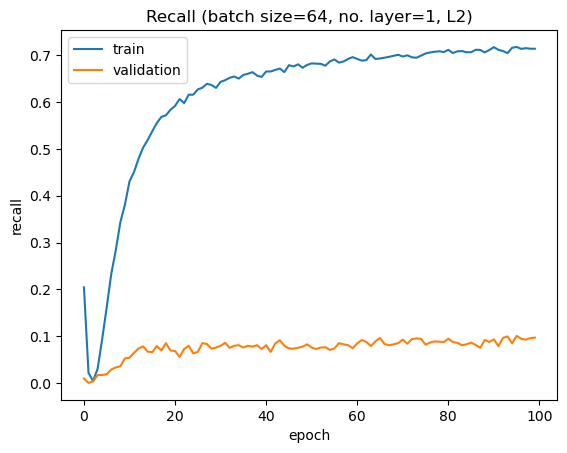

In [157]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [158]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.054
Training Accuracy: 0.94
Training Recall: 0.714


Validation Loss: 0.253
Validation Accuracy: 0.73
Validation Recall: 0.097


### batch size = 16, number of layer = 2

In [159]:
def create_shared_network(input_shape):
    model = keras.Sequential([
    
    keras.Input(shape=input_shape),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu')
        
    ])
    
    return model
    
def plt_metric(history, metric, title, batch_size):
    plt.plot(history[metric])
    plt.plot(history["val_" + metric])
    plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.xlabel("epoch")
    if "recall" in metric:
        plt.ylabel("recall")
        plt.savefig(".\L2_augmented\\densenet_{}_2_recall.png".format(batch_size))
    else:
        plt.ylabel(metric)
        plt.savefig(".\L2_augmented\\densenet_{}_2_{}.png".format(batch_size, metric))
    plt.show()

In [160]:
batch_size = 16
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
2400/2400 - 5s - loss: 0.1630 - accuracy: 0.7884 - recall_33: 0.0667 - val_loss: 0.1399 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 5s/epoch - 2ms/step
Epoch 2/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 3/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 4/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 5/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 1ms/step
Epoch 6/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy:

Epoch 48/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 49/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 50/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 51/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 52/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 53/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val

2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 95/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 96/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 97/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 98/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_33: 0.0000e+00 - 4s/epoch - 2ms/step
Epoch 99/100
2400/2400 - 4s - loss: 0.1389 - accuracy: 0.8333 - recall_33: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.

#### Predict

In [161]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

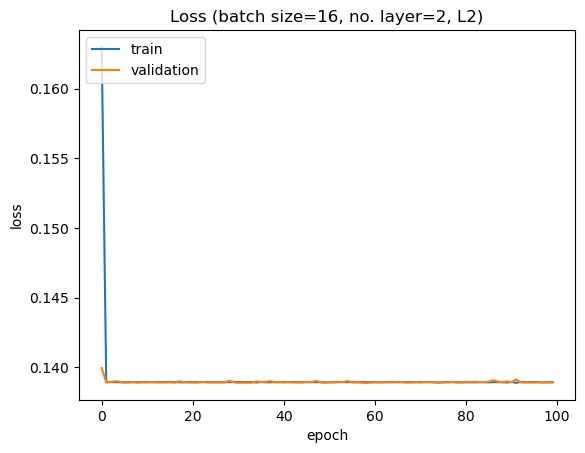

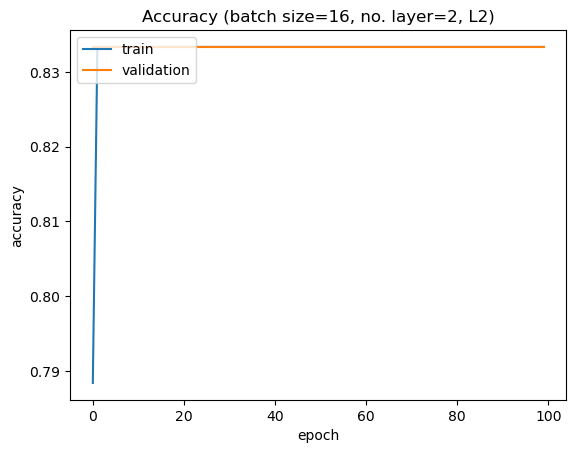

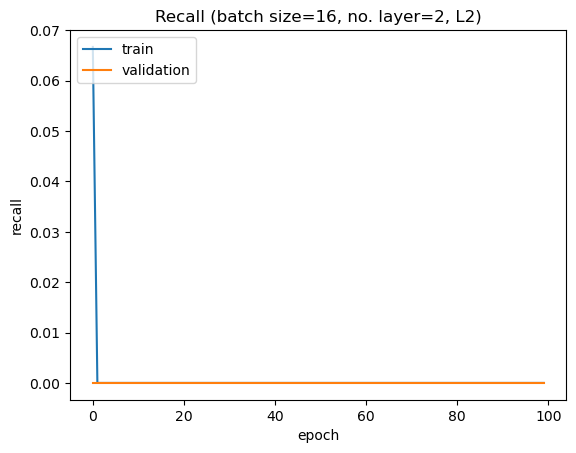

In [162]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [163]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.139
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.139
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 32, number of layer = 2

In [164]:
batch_size = 32
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
1200/1200 - 3s - loss: 0.1841 - accuracy: 0.7556 - recall_34: 0.1164 - val_loss: 0.1421 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 3s/epoch - 2ms/step
Epoch 2/100
1200/1200 - 2s - loss: 0.1392 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1392 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 3/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 4/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 5/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 6/100
1200/1200 - 2s - loss: 0.1389 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1389 - val_accuracy:

Epoch 48/100
1200/1200 - 2s - loss: 0.1377 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 49/100
1200/1200 - 2s - loss: 0.1377 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1408 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 50/100
1200/1200 - 2s - loss: 0.1378 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1406 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 51/100
1200/1200 - 2s - loss: 0.1375 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 52/100
1200/1200 - 2s - loss: 0.1377 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1407 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 53/100
1200/1200 - 2s - loss: 0.1376 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1409 - val

1200/1200 - 2s - loss: 0.1366 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1421 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 95/100
1200/1200 - 2s - loss: 0.1369 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1421 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 96/100
1200/1200 - 2s - loss: 0.1367 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 97/100
1200/1200 - 2s - loss: 0.1368 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1418 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 98/100
1200/1200 - 2s - loss: 0.1367 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.8333 - val_recall_34: 0.0000e+00 - 2s/epoch - 2ms/step
Epoch 99/100
1200/1200 - 2s - loss: 0.1368 - accuracy: 0.8333 - recall_34: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.

#### Predict

In [165]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

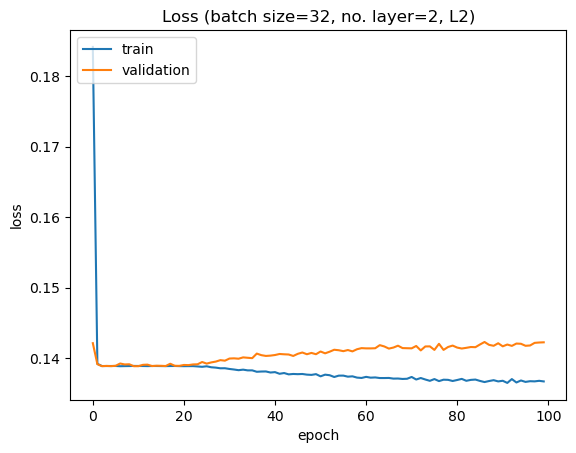

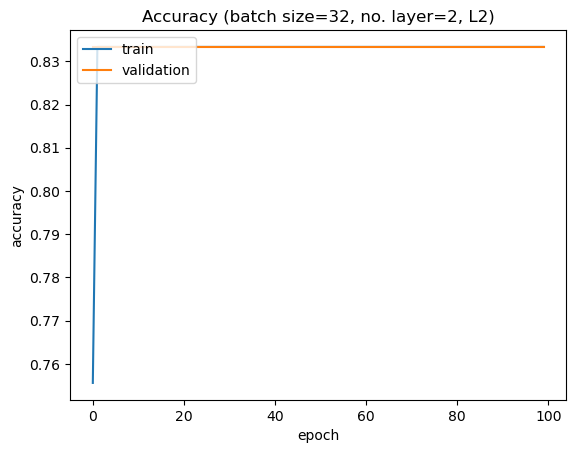

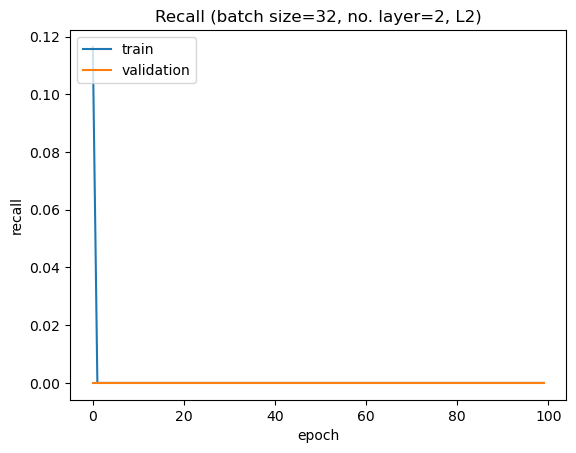

In [166]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [167]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.137
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.142
Validation Accuracy: 0.833
Validation Recall: 0.0


### batch size = 64, number of layer = 2

In [168]:
batch_size = 64
no_layer = 2

model = create_siamese_network(input_shape)
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=loss(), metrics=["accuracy", tf.keras.metrics.Recall()])

history = model.fit(
    [left_images, right_images],
    labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/100
600/600 - 2s - loss: 0.2039 - accuracy: 0.7828 - recall_35: 0.0764 - val_loss: 0.2061 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/100
600/600 - 1s - loss: 0.1452 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 3/100
600/600 - 1s - loss: 0.1390 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 962ms/epoch - 2ms/step
Epoch 4/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 5/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1389 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 6/100
600/600 - 1s - loss: 0.1389 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1390 - val_accuracy: 0.8333 -

Epoch 48/100
600/600 - 1s - loss: 0.1348 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1471 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 980ms/epoch - 2ms/step
Epoch 49/100
600/600 - 1s - loss: 0.1352 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1471 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 924ms/epoch - 2ms/step
Epoch 50/100
600/600 - 1s - loss: 0.1346 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1473 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 982ms/epoch - 2ms/step
Epoch 51/100
600/600 - 1s - loss: 0.1348 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1477 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 949ms/epoch - 2ms/step
Epoch 52/100
600/600 - 1s - loss: 0.1345 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1478 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 948ms/epoch - 2ms/step
Epoch 53/100
600/600 - 1s - loss: 0.1347 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1478 - 

Epoch 94/100
600/600 - 1s - loss: 0.1318 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1531 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 947ms/epoch - 2ms/step
Epoch 95/100
600/600 - 1s - loss: 0.1316 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1535 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 932ms/epoch - 2ms/step
Epoch 96/100
600/600 - 1s - loss: 0.1315 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1539 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 961ms/epoch - 2ms/step
Epoch 97/100
600/600 - 1s - loss: 0.1319 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1525 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 964ms/epoch - 2ms/step
Epoch 98/100
600/600 - 1s - loss: 0.1314 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1521 - val_accuracy: 0.8333 - val_recall_35: 0.0000e+00 - 980ms/epoch - 2ms/step
Epoch 99/100
600/600 - 1s - loss: 0.1316 - accuracy: 0.8333 - recall_35: 0.0000e+00 - val_loss: 0.1522 - 

#### Predict

In [169]:
predictions = model.predict([x_test_1, x_test_2])
predictions_flat = predictions.reshape(-1)
prediction_form = predictions_flat.reshape(2000, 20)
   
overall_score = pd.DataFrame(np.array(prediction_form))
overall_score.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19']

overall_score['left'] = list(test_candidates['left'])

cols = overall_score.columns.tolist()
cols = cols[-1:] + cols[:-1]
overall_score = overall_score[cols]

overall_score.to_csv('.\L2_augmented\\densenet_{}_{}.csv'.format(batch_size, no_layer), index=False)

#### Plot

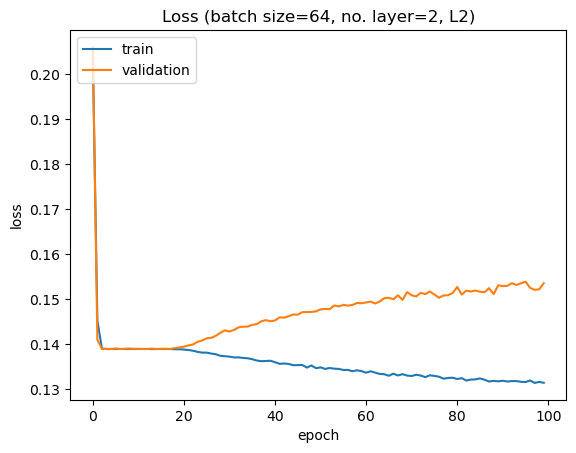

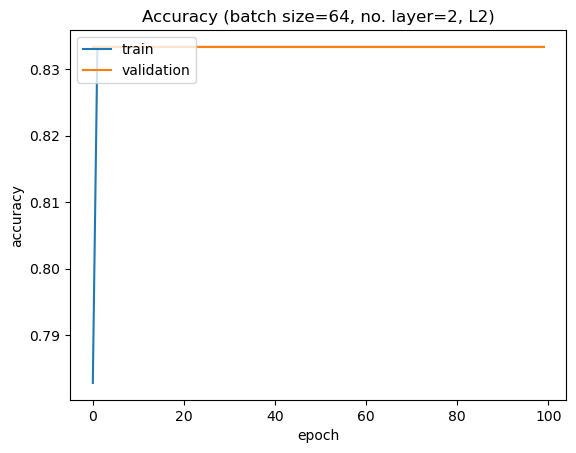

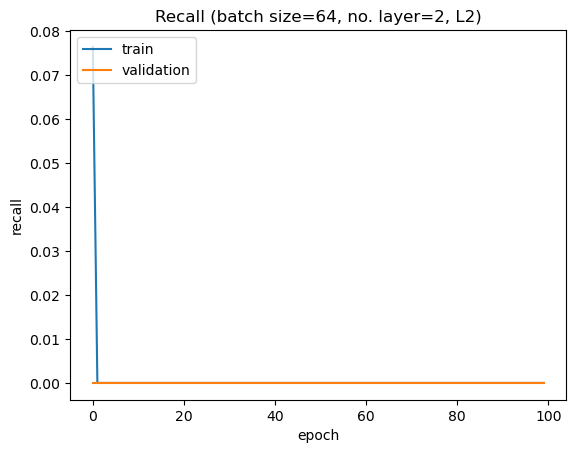

In [170]:
# Plot the loss
plt_metric(history=history.history, metric="loss", title="Loss (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)
    
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Accuracy (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

# Plot the recall
recall_name = ''
for i in history.history.keys():
    if 'recall' in i:
        recall_name = i
        break
plt_metric(history=history.history, metric=recall_name, title="Recall (batch size={}, no. layer={}, L2)".format(batch_size, no_layer),
           batch_size=batch_size)

In [171]:
valid_recall = ''
for i in history.history.keys():
    if 'val_recall' in i:
        valid_recall = i
        break

print("Training Loss: {}".format(round(history.history.get('loss')[-1], 3)))
print("Training Accuracy: {}".format(round(history.history.get('accuracy')[-1], 3)))
print("Training Recall: {}".format(round(history.history.get(recall_name)[-1], 3)))
print("\n")
print("Validation Loss: {}".format(round(history.history.get('val_loss')[-1], 3)))
print("Validation Accuracy: {}".format(round(history.history.get('val_accuracy')[-1], 3)))
print("Validation Recall: {}".format(round(history.history.get(valid_recall)[-1], 3)))


Training Loss: 0.131
Training Accuracy: 0.833
Training Recall: 0.0


Validation Loss: 0.154
Validation Accuracy: 0.833
Validation Recall: 0.0
